In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### *Authored by: Ethan Ma (em682), Josiah Kek (jrk322), Tiffany Liu (tzl4)*

# 1. Introduction

Every year, there are over 85 million taxi rides in New York City (NYC), crisscrossing the city with distinctive yellow cabs. The taxi system is essential for the 8 million New Yorkers, getting them to where they need to go and pumping the heart of the City That Never Sleeps. 

The NYC Taxi and Limousine Commission (TLC) has open-source data on the millions of rides taken in its yellow taxis from January to August 2019, while the National Weather Service keeps a detailed record of daily weather in NYC. 

Using both datasets, we seek to uncover the underlying factors and patterns that drive taxi ridership in NYC. To that end, we have structured our exploration to revolve around 3 key questions: 

1. **What are the General Trends in NYC Taxi Ridership?**


2. **A Daily Perspective: Which Variables are the Best Predictors of Daily Trip Counts?**


3. **Zooming into Manhattan: Which Variables are Best for Predicting the Odds of a Downtown Pickup/Dropoff for Manhattan Rides?**

The answers to these questions give us a window into where, when and why New Yorkers decide to commute by taxi. These findings may be of interest to city lovers, urban planners and policymakers alike, and we hope to add to the discussion on how transportation in dense cities can be improved. 


Our main findings are as follows:
1. **General Trends:** 
 - Taxi ridership exhibits strong seasonality, with large variations between months and across 24 hours of a day. 
 <br />
 
 - The vast majority of NYC taxi rides are short hops (between 1 and 3.1 miles), and the median speed of a taxi ride is surprisingly slow (short of 10 miles).
 <br />
 
 - The varying densities of hourly taxi rides on weekends and weekdays are suggestive of the potential heavy use of taxis by the late-night party crowd to get home on weekends, as well as by the working crowd to commute to work on weekdays. 
 

2. **Best Predictors of Daily Trip Counts:** 
 - Weather has a strong relationship with daily trip counts. For instance, an increase in average temperature or new daily snowfall by a small amount is linked to sharp drops in daily taxi ridership.  
 <br />
 
 - Both day of week and 2019 month are key predictors of daily taxi ridership. Thursdays and Fridays are linked to the largest rise in daily trip counts (as compared to other days), while June-August 2019 are linked to a precipitous fall in daily trip counts (as compared to January-May 2019). 
 
 
3. **Best Predictors of a Downtown Pickup/Dropoff for Manhattan Rides**
 - When looking solely at Manhattan rides, the odds of a ride having a downtown origin/destination increases substantially on a weekend or late night. 
 <br />
 
 - Card payment is linked to a sharp increase in downtown ride odds (as compared to cash payments). 
 <br />
 
 - A higher total amount paid is linked to greater odds of a downtown ride, when covariates are held constant. 
 
This project uncovers both NYC taxi ridership trends and the underlying factors that drive them, from seasonality to weather and location. In the process, it sheds light on the lives of the individual people of NYC&mdash;ranging from the Wall Street banker to the Central Park jogger to the East Village partygoer&mdash;while also giving valuable insights for policymaking. 

# 2. Data Description 

## 2.1 Overview

For this project, we drew on and combined two sources of data:

1. Detailed trip-level data on daily NYC taxi ridership from January to August 2019, obtained from the New York City Taxi and Limousine creation website (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The data came in the form of 8 monthly datasets of yellow taxi ridership, adding up to 57 million observations and a size of 5.2GB. 


2. Daily NYC weather data (from Central Park) for January to August 2019, scraped from the National Weather Service website (https://w2.weather.gov/climate/xmacis.php?wfo=okx).

Our data was preprocessed by drawing random samples of 0.2% of each of the 8 monthly taxi datasets, concatenating the 8 sample sets into one dataset, before joining it to the NYC weather dataset. Illogical entries (e.g. negative taxi fares) and null values were then dropped, as further explained below. Our curated dataset can be found at https://cornell.box.com/s/cptp2tgln6sxo86ecfmszfrzwew0qud9. 

We will join the aforementioned dataset to a taxi zone lookup dataset in Section 5.1 (point of use). The taxi zone lookup dataset matches 265 location IDs to location names, and classifies Manhattan locations into zones (e.g. Uptown, Midtown, Downtown) that we coded based on a Manhattan map. 

## 2.2 What are the observations (rows) and the attributes (columns)?

The observations are unique taxi trips taken on a yellow taxi in NYC from January to August 2019. 

In [2]:
#importing "nyc_taxis_weather_jantoaug19s.csv"
df=pd.read_csv("nyc_taxis_weather_jantoaug19s.csv")

#casting all date-related variables into datetime objects
df["pickup_datetime"]=pd.to_datetime(df['pickup_datetime'])
df["dropoff_datetime"]=pd.to_datetime(df['dropoff_datetime'])
df["date"]=pd.to_datetime(df['date'])

#reordering the columns to group related attributes together
df=df[["pickup_datetime","dropoff_datetime","pickup_dayofweek","PULocationID","DOLocationID","trip_distance","trip_duration_mins","fare_amount","tip_amount","tolls_amount","congestion_surcharge","improvement_surcharge","mta_tax","extra","total_amount","payment_type","RatecodeID","store_and_fwd_flag","passenger_count","date","maxtemp","mintemp","avetemp","departuretemp","hdd","cdd","precipitation","newsnow","snowdepth"]]
df.head()

,pickup_datetime,dropoff_datetime,pickup_dayofweek,PULocationID,DOLocationID,trip_distance,trip_duration_mins,fare_amount,tip_amount,tolls_amount,...,date,maxtemp,mintemp,avetemp,departuretemp,hdd,cdd,precipitation,newsnow,snowdepth
0,2019-01-17 18:30:40,2019-01-17 18:35:20,3,162,233,0.70,4.67,5.0,1.36,0.0,...,2019-01-17,33,24,28.5,-3.7,36,0,0.00,0.0,0.0
1,2019-01-07 20:45:41,2019-01-07 21:10:25,0,186,75,5.29,24.73,19.5,0.00,0.0,...,2019-01-07,34,25,29.5,-3.2,35,0,0.00,0.0,0.0
2,2019-01-29 10:00:49,2019-01-29 10:07:37,1,236,237,0.65,6.80,6.0,0.00,0.0,...,2019-01-29,43,25,34.0,1.1,31,0,0.23,0.0,0.0
3,2019-01-10 05:54:57,2019-01-10 06:12:44,3,211,138,10.10,17.78,29.0,0.00,0.0,...,2019-01-10,34,28,31.0,-1.4,34,0,0.00,0.0,0.0
4,2019-01-24 08:59:00,2019-01-24 09:12:27,3,233,170,0.47,13.45,9.0,0.50,0.0,...,2019-01-24,59,35,47.0,14.5,18,0,1.33,0.0,0.0


The attributes provide detailed information on various aspects of a taxi ride. These include:

- `pickup_datetime`/`dropoff_datetime`: The date and time when the taximeter is engaged/disengaged in a taxi ride respectively
- `pickup_dayofweek` _(attribute created by us)_ **:** The day of week of pick-up, coded from Monday =0 to Sunday =6
- `PULocationID`/`DOLocationID`: The Taxi Zone (corresponding to a 265 zones listed on the TLC website) in which the taximeter was engaged/disengaged
- `trip_distance:` The elapsed trip distance in miles reported by the taximeter.
- `trip_duration_mins` _(attribute created by us)_ **:** The duration of a trip, computed by finding the time difference between `pickup_datetime` and `dropoff_datetime`
- `fare_amount:` The time-and-distance fare calculated by the meter
- `tip_amount:` Amount of credit card tips. Cash tips are not included.
- `tolls_amount:` Total amount of all tolls paid.
- `congestion_surcharge:`** \\$2.50 surcharge for non-shared trips in taxicabs
- `improvement_surcharge:` \\$0.30 improvement surcharge assessed trips at the flag drop
- `mta_tax:` \\$0.50 MTA tax that is automatically triggered based on the metered rate in use.
- `extra:` Miscellaneous extras and surcharges. Currently, this only includes the \\$0.50 and \\$1 rush hour and overnight charges
- `total_amount:` The total amount charged to passengers. Does not include cash tips.
- `payment_type:` A numeric code signifying how the passenger paid for the trip.
  - 1 = Credit card 
  - 2 = Cash
  - 3 = No charge 
  - 4 = Dispute
  - 5 = Unknown 
  - 6 = Voided trip
- `RateCodeID`: The final rate code in effect at the end of the trip.
 - 1= Standard rate
 - 2=JFK
 - 3=Newark
 - 4=Nassau or Westchester 5=Negotiated fare 6=Group ride
- `store_and_fwd_flag:` Indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.
- `passenger_count:` Number of passengers in a taxi
- `date`: The data of a taxi ride (used for us to track a successful join with the weather dataset)
- `maxtemp:` The daily maximum temperature recorded at Central Park (degrees F)
- `mintemp:` The daily minimum temperature recorded at Central Park (degrees F)
- `avetemp:` The daily average temperature recorded at Central Park (degrees F)
- `departuretemp:` The average temperature departure from normal (degrees F)
- `hdd:` Heating degree days recorded at Central Park (base 65)
- `cdd:` Cooling degree days recorded at Central Park (base 65)
- `precipitation:` The daily precipitation recorded at Central Park (inches)
- `newsnow:` The daily new snowfall recorded at Central Park (inches)
- `snowdepth:` The daily snow depth recorded at Central Park (inches)

##  2.3 Why was this dataset created?

This dataset was created to analyze the potential impact of various factors on taxi ridership in New York City, with particular attention given to weather, time of day, payment method, and location. This dataset also allows for the exploration of potential correlation between different attributes, and seeks to answer questions such as "How are duration of ride and time of day related?" "Are there trends in popular pick up locations in the late-night hours compared to in the morning?" and "What is the correlation, if any, between payment method and pick up location?" Ultimately, this dataset was created to learn more about the trends and patterns that affect the vast network of taxis, as well as taxi riders, across New York City.

This data draws directly on 2 other datasets, a dataset published by the NYC Taxi and Limousine Commission and a dataset published by the National Weather Service. The taxi dataset was created for similar reasons to this dataset: to observe changing trends in taxi ridership across the city and hopefully inform decisions in the industry and improve the overal taxi system. The weather dataset was created for reasons entirely separate from taxi riding and is instead part of a much larger data collection conducted across the country for the purposes of predicting trends in weather and climate, from daily temperatures to natural disasters. 

##  2.4 Who funded the creation of the dataset?

This dataset did not receive any external funding and was independently compiled from external data sources by students at Cornell University. The raw taxi dataset was collected by various technology providers funded and authorized by the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The weather dataset was collected from sources at the National Climactic Data Center, a subset of the National Oceanic and Atmospheric Adminstration, which is funded by the United States Department of Commerce. 

##  2.5 What processes might have influenced what data was observed and recorded and what was not?

###  Taxi Dataset

In the taxi dataset, the type of data observed and recorded is influenced by concerns of usefulness, measurability and privacy. 

Certain attributes (such as `Fare_amount`, `PULocationID` and `trip_distance`) are useful as they help TLC assess the health and profitability of the industry it is regulating. TLC may act on those attributes to draft new policies (e.g. enforcing the fare rate in taxis, buying taxi models that are more fuel-efficient for short trips).


Other attributes (such as `store_and_fwd_flag`) are collected just because they are measurable. While the significance of knowing whether a trip record was held in vehicle memory is unclear, the ease of measuring this attribute with taxi sensors likely led to its inclusion in the taxi dataset. The lack of measurability is also why certain useful attributes (such as "satisfaction rate of customers" or "fatigue level of drivers") are not included in the dataset&mdash;they are simply not measurable with current sensors in taxis.

Privacy concerns limit both what attributes can be observed and the granularity of observations. For instance, due to privacy laws, we cannot record attributes like "passenger age" or "passenger occupation", no matter how useful/measurable those attributes might be. Also, we can only observe pick-up/drop-off location data as coded into general zones (LocationIDs), rather than in a more granular form such as "pick-up/drop-off address". 

### Weather Dataset

In the weather dataset, the type of data observed and recorded was influenced by level of comparability and measurability. 

Given that weather data is often aggregated and averaged by region (e.g. NYC), and compared among regions (e.g. NYC vs Boston), the type of data observed is determined by its suitability for comparison. Due to this focus on comparability, the attributes observed (e.g. `maxtemp`, `mintemp`, `precipitation`) are very standard across weather stations in the US and are measured in standard units (e.g. F, inches). 

Measurability is a key factor as niche equipment is needed to observe various aspects of weather precisely. In Central Park, weather data is collected by an automated weather station on Belvedere Castle. The observed attributes are based on what can be reliably measured by an automated system with little human oversight. 

##  2.6 What preprocessing was done, and how did the data come to be in the form that you are using?

### Step 1: Data Collection and Concatenation

- The 8 monthly taxi datasets were downloaded from the TLC website, constituting 57,080,500 taxi trips and 5.2GB of data in all. For each month, a random sample of 0.2% of observations was drawn, adding up to around 14,200 taxi trips per month. Each random sample was screened using _Series.unique( )_ to ensure that there was there was an even distribution of days in the month. 


- The 8 samples were concatenated into a single taxi dataset ("taxis_jantoaug19s.csv") that contained 113,687 taxi trips from January to August 2019. 


- The NYC (Central Park) weather dataset from January to August 2019 was scraped from the National Weather Service website and saved as "nyc_weather_jantoaug19.csv".


- The taxi zone lookup dataset was downloaded from the TLC website. We looked up the 265 location names on Google Maps and, if they were in Manhattan, classified them into 4 zones (Uptown, Midtown, Lower-Midtown, Downtown). The classifications were added under a new attribute, `manhattan_zone`. 

### Step 2: Data Cleaning of Taxi Dataset (in order of steps)


- From the "taxis_jantoaug19s.csv" dataset with 113,687 observations, 9752 null values for `congestion_surcharge` were replaced with 0. 


- A new `trip_duration_mins` attribute was created by finding the difference between `dropoff_datetime` and `pickup_datetime`, before dividing that by _np.timedelta64(1,'m')_.


- A new `pickup_dayofweek` attribute was created by applying _Series.dt.dayofweek_ to `pickup_datetime`.



- Obvious irregularities in "taxis_jantoaug19s.csv" were detected and fixed. An observation with `pickup_datetime` and `dropoff_datetime` correponding to a non-2019 year was removed, along with 111 observations with negative `congestion_surcharge` values.


- 993 observations that violated our assumptions of a "valid" taxi ride&mdash;positive values for `fare_amount`, `trip_distance`, `total_amount` and `trip_duration_mins`&mdash;were removed.


- All 628 of the remaining null values in the dataset were removed. 


- 505 observations with `payment_type` of 3 (no charge) or 4 (disputed) were removed.


- The `Vendor_ID` attribute was dropped due to its limited relevance. 

### Step 3: Data Integration and Cleaning of Merged Dataset

- The taxi and weather datasets were combined by left-joining "taxis_jantoaug19s.csv" to to "nyc_weather_jantoaug19.csv" on `pd.to_datetime(df_taxis["pickup_datetime"]).dt.date`=`pd.to_datetime(df_weather['date']).dt.date`


- The `pickup_datetime` and `date` fields in the joined dataset were checked to ensure a successful join. The joined dataset, containing 111953 taxi rides, was saved as "nyc_taxis_weather_jantoaug19s.csv". 


- Trace values of `precipitation`, `newsnow` and `snowdepth`, denoted by "T" in the raw dataset, were replaced by 0. This affected 13,220 observations. 


- The cleaned and preprocessed dataset, with 111,953 observations, was saved to "nyc_taxis_weather_jantoaug19s.csv", which can be accessed at https://cornell.box.com/s/cptp2tgln6sxo86ecfmszfrzwew0qud9.

##  2.7 If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?



No personal information or data was collected from individuals in the creation of the weather dataset or the taxi dataset. Although the taxi dataset indirectly involves people as taxi riders, who may not have been made aware that information about their ride would be recorded, the dataset has nothing to do with the individuals as people and focuses instead on information pertaining to the taxi ride itself, as collected and recorded by taxi companies. 

##  2.8 Where can your raw source data be found, if applicable?

Our 8 taxi monthly datasets can be found on the TLC website (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) and are each titled "Yellow Taxi Trip Records". The links to download them are as provided:
- January 2019 dataset (https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv)
- February 2019 dataset (https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-02.csv)
- March 2019 dataset (https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-03.csv)
- April 2019 dataset (https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-04.csv)
- May 2019 dataset (https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-05.csv)
- June 2019 dataset (https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv)
- July 2019 dataset (https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-07.csv)
- August 2019 dataset (https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-08.csv)

The weather dataset can be scraped off the National Weather Service website (https://w2.weather.gov/climate/xmacis.php?wfo=okx) by copying the table into an Excel sheet prior to conversion to a CSV file. 

The taxi zone lookup dataset (which we join on in Section 5.1) can be downloaded at https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv. The raw dataset does not contain Manhattan zones. 

# 3. What are the General Trends in NYC Taxi Ridership?

The thousands of neon yellow taxis that crisscross NYC streets every minute carry in them the pulse of the world's greatest city. We would first like to put a finger on this pulse by exploring general trends in our taxi ridership dataset.

To that end, we will look at time series trends, along with measures of central tendency for a variety of variables. 

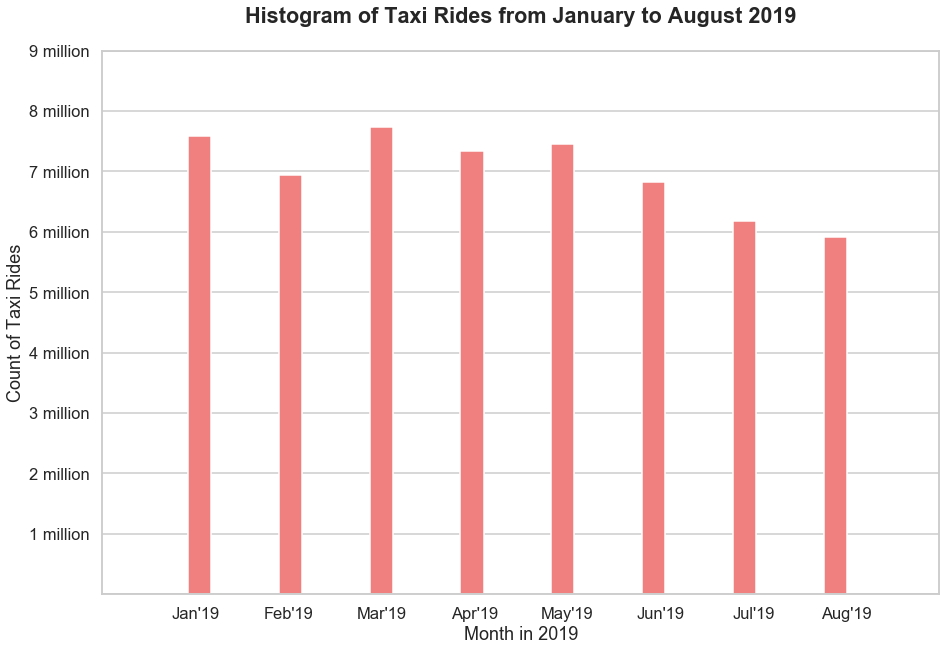

In [3]:
# plotting histogram of taxi rides from january to august 2019
plt.figure(figsize=(15,10))
sns.set(context="talk", style="whitegrid", palette="bright")
g=sns.distplot(df["pickup_datetime"].dt.month, kde=False, hist_kws={"width":0.25,"align":"left","color":"lightcoral", 'alpha': 1})
g.xaxis.grid(b=False)
plt.xlim(0,9)
g.set_xticklabels(["","Jan'19","Feb'19","Mar'19","Apr'19","May'19","Jun'19","Jul'19","Aug'19"])
# rescaling y ticks to account for how we sampled 0.002 of the dataset
plt.yticks(g.get_yticks(), (g.get_yticks() * 1/0.002).astype(int))
g.set_yticklabels(["","1 million","2 million","3 million","4 million","5 million","6 million","7 million","8 million","9 million"])
plt.xlabel("Month in 2019")
plt.ylabel("Count of Taxi Rides")
plt.title("Histogram of Taxi Rides from January to August 2019", fontweight="bold", fontsize="large", y=1.04)
plt.show()

From January to August 2019, there was an average of 7 million taxi rides in NYC each month. There is a sizable variation in monthly taxi ridership, with March taxi rides outnumbering those in August by 1.82 million. 

Overall, there is a noticeable trend, possibly due to changes in seasonal behavior or environmental factors, that monthly taxi ridership falls as the year goes on. 

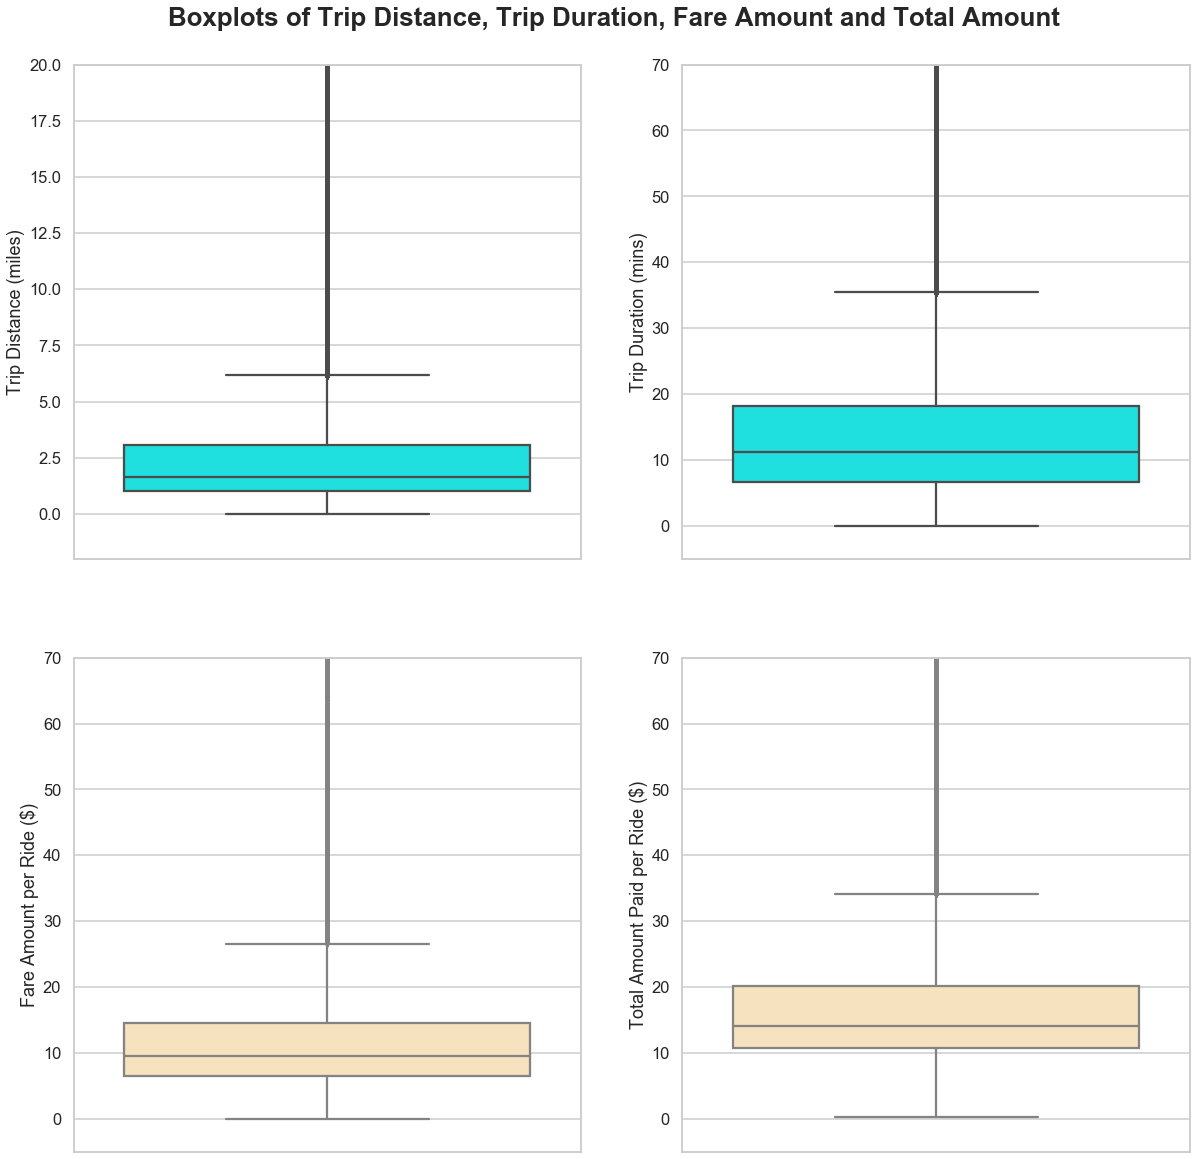

In [4]:
fig,axes=plt.subplots(2,2, figsize=(20,20))

# plotting boxplot of trip distance
a=sns.boxplot(y=df['trip_distance'], ax=axes[0,0],color="cyan").set(ylabel='Trip Distance (miles)')
axes[0,0].set(ylim=(-2, 20))

# plotting boxplot of trip duration
sns.boxplot(y=df['trip_duration_mins'], ax=axes[0,1],color="cyan").set(ylabel='Trip Duration (mins)')
axes[0,1].set(ylim=(-5, 70))

# plotting boxplot of fare amount
sns.boxplot(y=df['fare_amount'], ax=axes[1,0],color="moccasin").set(ylabel='Fare Amount per Ride ($)')
axes[1,0].set(ylim=(-5, 70))

# plotting boxplot of total amount
sns.boxplot(y=df['total_amount'], ax=axes[1,1],color="moccasin").set(ylabel='Total Amount Paid per Ride ($)')
axes[1,1].set(ylim=(-5, 70))

fig.suptitle('Boxplots of Trip Distance, Trip Duration, Fare Amount and Total Amount', fontsize="x-large", fontweight="bold", y=0.92)
plt.show()

Looking at the top left boxplot, the vast majority of NYC taxi rides are short hops, with a median trip distance of just 1.64 miles and a narrow interquartile range of 2.07 miles. This is expected for a dense city like NYC where spaces for living, working, dining and recreation are in close proximity and do not require long-distance taxi rides to travel between. 

As for trip duration (depicted in the top right boxplot), the median stands at 11.13 minutes per ride. There is much more variation in trip durations, with a wide interquartile range of 11.5 minutes, which is unsurprising given the large variability in NYC traffic conditions. The median trip speed (which we calculated by dividing the distance variable over duration) is a slow 9.96 miles per hour. Perhaps some of these taxi commuters should consider using the subway!

For fare amount and total amount, there are a sizable number of outliers (such as fare amounts exceeding \\$300), thus it is justifiable to focus on the median instead of the mean. The median fare amount is \\$9.50, while the median total amount (which includes fares, tolls and tips) is \\$14.16, both of which are pretty expected for a taxi ride in NYC. 

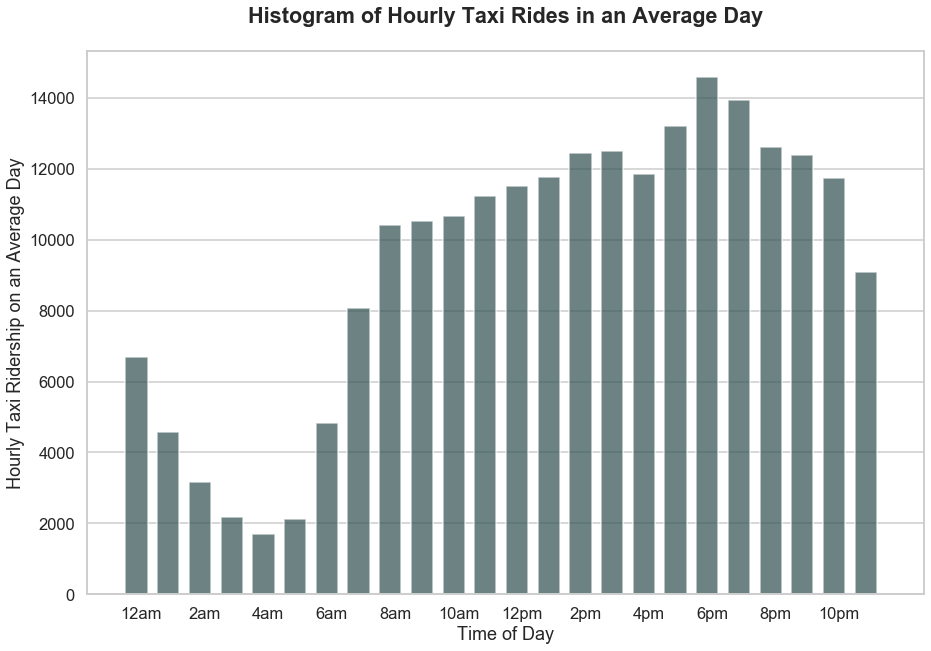

In [5]:
# scaling df to a daily time frame: dividing by 0.002 as we sampled 0.002 of dataset, and dividing by 242 as there are 242 days in our sample
scaled_daily_df = pd.concat([df]*round(1/0.002/242))

# plotting distribution plot of hourly taxi rides in an average day
plt.figure(figsize=(15,10))
g=sns.distplot(pd.to_datetime(scaled_daily_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,1)-0.5, kde=False, hist_kws={"width":0.7, "color":"darkslategray", 'alpha': 0.7})
g.xaxis.grid(b=False)
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylabel("Hourly Taxi Ridership on an Average Day")
plt.title("Histogram of Hourly Taxi Rides in an Average Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

What is the hourly distribution of NYC taxi rides like on an average day? 

As daylight breaks, there is a sharp jump in taxi rides from 6am onwards, and hourly taxi ridership doubles from 4,832 at 6-7am to 10,674 at 10-11am. Hourly taxi ridership remains high throughout the day, climbing through the lunchtime hours and afternoon, before reaching its daily peak of 14,600 at 6-7pm, when the office crowd gets off work. Thereafter, hourly ridership remains high until 11pm, after which there is a sharp dropoff in rides. 

Even in "The City That Never Sleeps", there is enormous variation in hourly taxi ridership throughout the day, with 8 times more rides at 6-7pm than at 4-5am. 

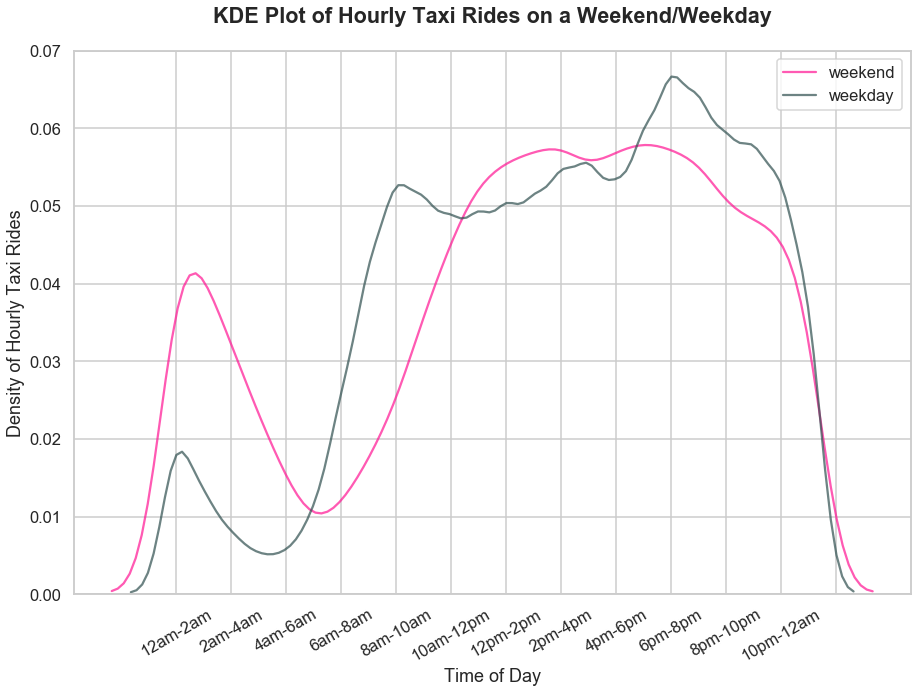

In [6]:
# creating "isweekend_df" dataframe that contains an `isweekend` attribute (whether a day is a weekend)
isweekend_df=scaled_daily_df.copy()
isweekend_df["isweekend"]=isweekend_df["pickup_dayofweek"].isin([5,6])
isweekend_df=isweekend_df.astype({'isweekend': 'int32'})

# creating subsets of `isweekend_df` to make graph plotting easier later on
isweekend_y_df=isweekend_df[isweekend_df["isweekend"]==1]
isweekend_n_df=isweekend_df[isweekend_df["isweekend"]==0]

df[df["trip_duration_mins"]==0]["trip_distance"]

# accounting for how weekends occur 2/7 and weekdays occur 5/7 of the time
scaled_isweekend_y_df = pd.concat([isweekend_y_df]*5)
scaled_isweekend_n_df = pd.concat([isweekend_n_df]*2)

# plotting KDE plot of hourly taxi rides on a weekend/weekday
plt.figure(figsize=(15,10))
sns.distplot(pd.to_datetime(isweekend_y_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend", kde_kws={"color":"deeppink", 'alpha': 0.7})
sns.distplot(pd.to_datetime(isweekend_n_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False,  label="weekday", kde_kws={"color":"darkslategray", 'alpha': 0.7})
plt.xticks(np.arange(0,25,2), labels=["12am-2am","2am-4am","4am-6am","6am-8am","8am-10am","10am-12pm","12pm-2pm","2pm-4pm","4pm-6pm","6pm-8pm","8pm-10pm","10pm-12am"], rotation=30)
plt.xlabel("Time of Day")
plt.ylabel("Density of Hourly Taxi Rides")
plt.legend()
plt.title("KDE Plot of Hourly Taxi Rides on a Weekend/Weekday", fontweight="bold", fontsize="large", y=1.04)
plt.show()

As weekdays turn into weekends, ties are loosened, suits are cast aside and a different rhythm of taxi ridership emerges&mdash;as reflected by the stark shift in the distribution of hourly taxi rides. 

On weekends, a higher density of taxi rides occurs in the late night through early hours of the morning (12-4am), perhaps due to the large crowds staying out late for parties. There is also a sleepier start to a weekend morning, as suggested by a much lower&mdash;and less steep increase in&mdash;the density of taxi rides occurring from 6-10am. On weekday evenings, unsurprisingly, we do not see the same spike in taxi ridership that occurs from 5-8pm on weekdays as the office crowd knocks off from work. 

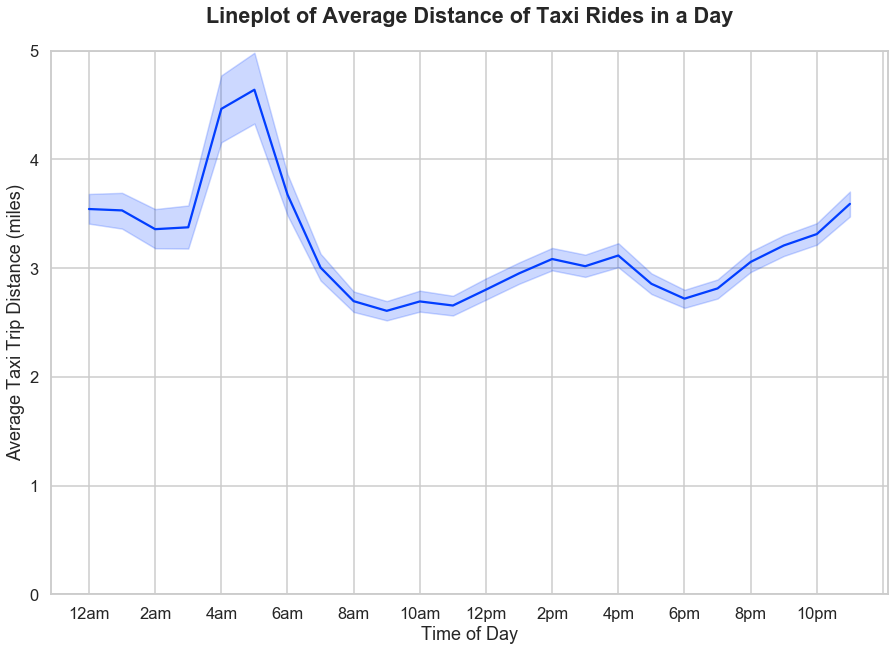

In [7]:
#plotting lineplot of average distance of taxi rides in a day
plt.figure(figsize=(15,10))
g=sns.lineplot(pd.to_datetime(df['pickup_datetime']).dt.hour, df["trip_distance"])
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylim(0,5)
plt.ylabel("Average Taxi Trip Distance (miles)")
plt.title("Lineplot of Average Distance of Taxi Rides in a Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Looking at average taxi trip distance throughout a day could hold clues about the roles that taxis play in New Yorkers' daily lives. 

The lineplot above shows that average trip distance peaks at above 3.5 miles between 3 and 6am. Given that the KDE plot previously showed that the fraction of rides at that time is much higher on weekends, it is possible that many rides at that time are by partygoers who need a safe ride home (no matter how far home is). It could also be that NYC public transit services are operating at reduced frequencies from 3-6am, thus prompting more long-distance rides that substitute the role of public transit. 

The lower average trip distances from 8-11am suggest that yellow taxis are more used for shorter-distance commutes to work. For New Yorkers who live outside Manhattan (e.g. Queens, Brooklyn) and work in Manhattan, they would likely take green taxis ("Boro taxis") for the long-distance ride as those are more prevalent in other boroughs. 

Average taxi trip distance stays relatively steady for the remainder of the day, before rising in the late night, perhaps as New Yorkers use hail yellow taxis in Manhattan for outbound travel. 

Having uncovered key trends in NYC taxi ridership, we will proceed with the problem of predicting daily taxi ridership in NYC.  

# 4. A Daily Perspective: Which Variables are the Best Predictors of Daily Trip Counts?

## 4.1 Laying the Foundations

Now, we will explore the question of which variables are best used to predict daily trip counts. The search for an answer will uncover the hidden factors that drive millions of commuters' decisions to ride in yellow taxis each day. 

For this part, we will create a new dataframe ("trip_counts_df") that aggregates trip counts by dates. 

In our full dataset, there were two kinds of variables&mdash;trip-basis variables (e.g. `fare_amount`,`trip_distance`) and day-basis variables (e.g. `max_temp`,`date`). Here, we omit all trip-basis variables as they are no longer relevant from a daily perspective. 

In [8]:
# creating a new dataset ("trip_count_by_date_df") that groups trip counts by date
trip_count_by_date_df = df.groupby("date")["pickup_datetime"].count()
trip_count_by_date_df = trip_count_by_date_df.to_frame(name="trip_count")
trip_count_by_date_df.reset_index(inplace=True)

# merging "trip_count_by_date_df" to weather data
trip_counts_df = trip_count_by_date_df.merge(df[["date","maxtemp","mintemp","avetemp","hdd","cdd","precipitation","newsnow","snowdepth","pickup_dayofweek"]], how="inner", on="date")

## 4.2 Dealing with Seasonality

We suspect that day-to-day taxi ridership would have a strong seasonal trend. For instance, large numbers of investment bankers may commute to work by taxi every Monday, but spend time at home or playing golf (and hence not taking the taxi) every Sunday. We will use a time series plot to understand the seasonal trend&mdash;particularly the length of each season and the magnitude of fluctuation across seasons. 

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


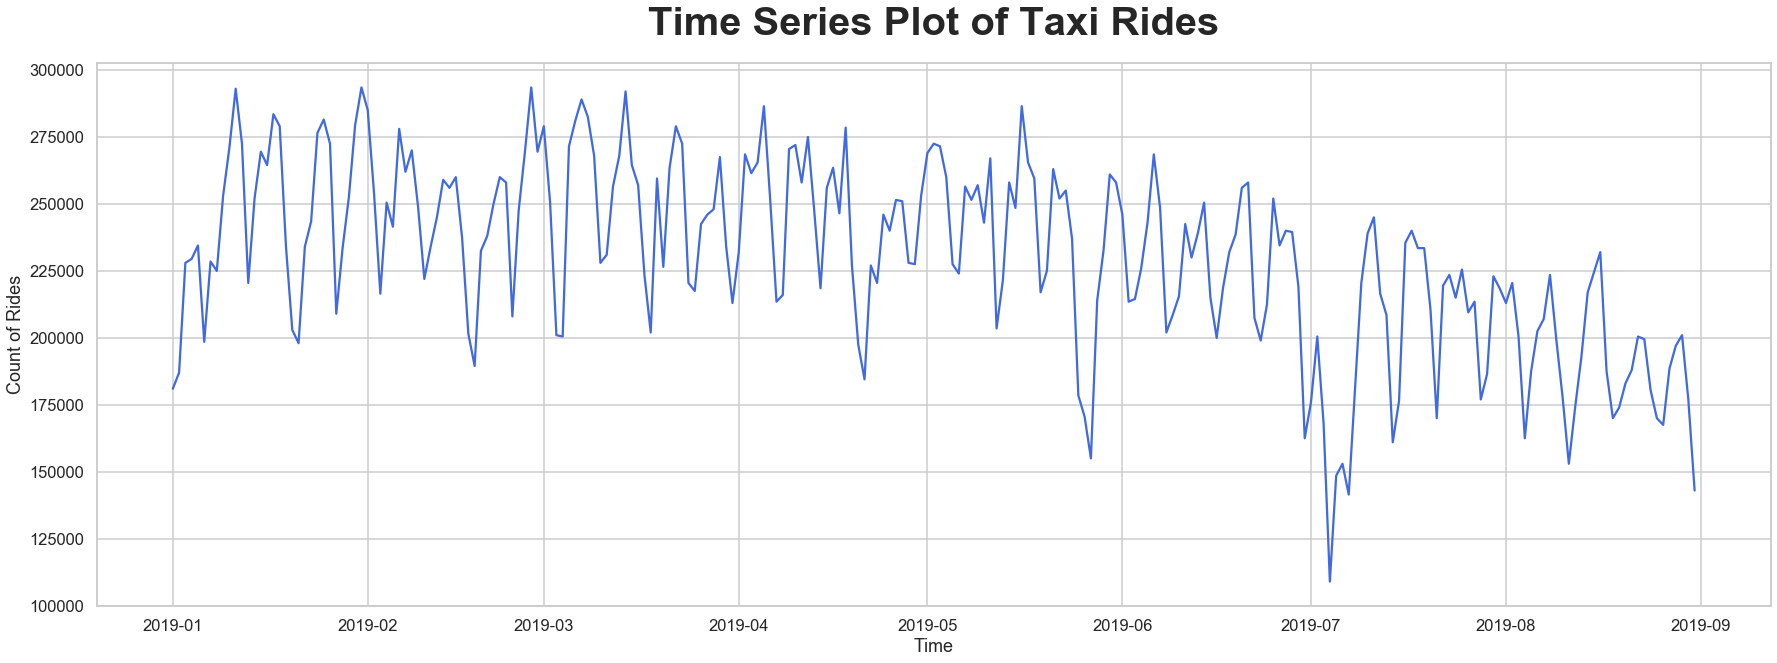

In [9]:
# plotting time series plot of taxi rides
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(trip_counts_df["date"],trip_counts_df["trip_count"], color="royalblue")
ax.set_title("Time Series Plot of Taxi Rides", fontweight="bold", fontsize="40", y=1.04)
ax.set_xlabel("Time")
ax.set_ylabel("Count of Rides")
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
plt.show()

The time series plot shows approximately four peaks and troughs each month, thus indicating a weekly trend. The magnitude of fluctuation is very large, with a difference of up to 75,000 rides between each peak and trough. 

There is also a monthly trend, with monthly taxi ridership decreasing as the months go by.

To capture this seasonality in our dataset (and subsequent model), we will create the following variables:

- `isweekend`: a binary variable that codes whether the date is a weekend *(1: yes, 0: no)*
- 6 dummy variables for the day of week (`monday`, `tuesday`, `wednesday`, `thursday`,`friday`, `saturday` and `sunday`)
- 8 dummy variables for month of 2019 (`january`, `february`, `march`, `april`, `may`, `june`, `july`, `august`)

In [10]:
trip_counts_df["isweekend"]=np.where(trip_counts_df["pickup_dayofweek"].isin([5,6]),1,0)

# creating 6 dummy variables for day of week
PUdayofweek_dummies=pd.get_dummies(trip_counts_df["pickup_dayofweek"])
PUdayofweek_dummies.rename(columns={0:"monday",1:"tuesday",2:"wednesday",3:"thursday",4:"friday",5:"saturday",6:"sunday"}, inplace=True)
trip_counts_df=trip_counts_df.join(PUdayofweek_dummies)

# creating 8 dummy variables for month of 2019
PUmonth_dummies=pd.get_dummies(trip_counts_df["date"].dt.month_name())
trip_counts_df=trip_counts_df.join(PUmonth_dummies)
trip_counts_df.rename(columns={"January":"january","February":"february","March":"march","April":"april","May":"may","June":"june","July":"july","August":"august"}, inplace=True)

#reordering columns
trip_counts_df=trip_counts_df[['date', 'trip_count', 'maxtemp', 'mintemp', 'avetemp', 'hdd', 'cdd',
       'precipitation', 'newsnow', 'snowdepth', 'pickup_dayofweek',
       'isweekend', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august']]

In [11]:
trip_counts_df["pickup_month"]=trip_counts_df["date"].dt.month_name()

## 4.3 Examining Correlations with `trip_count` through Visualizations

First, we will use a correlation heatmap to identify explanatory variables with noticeable correlations with our response variable (`trip_count`). We are looking out for squares in the heatmap with a reddish or bluish hue (absolute correlations of more than 0.1). 

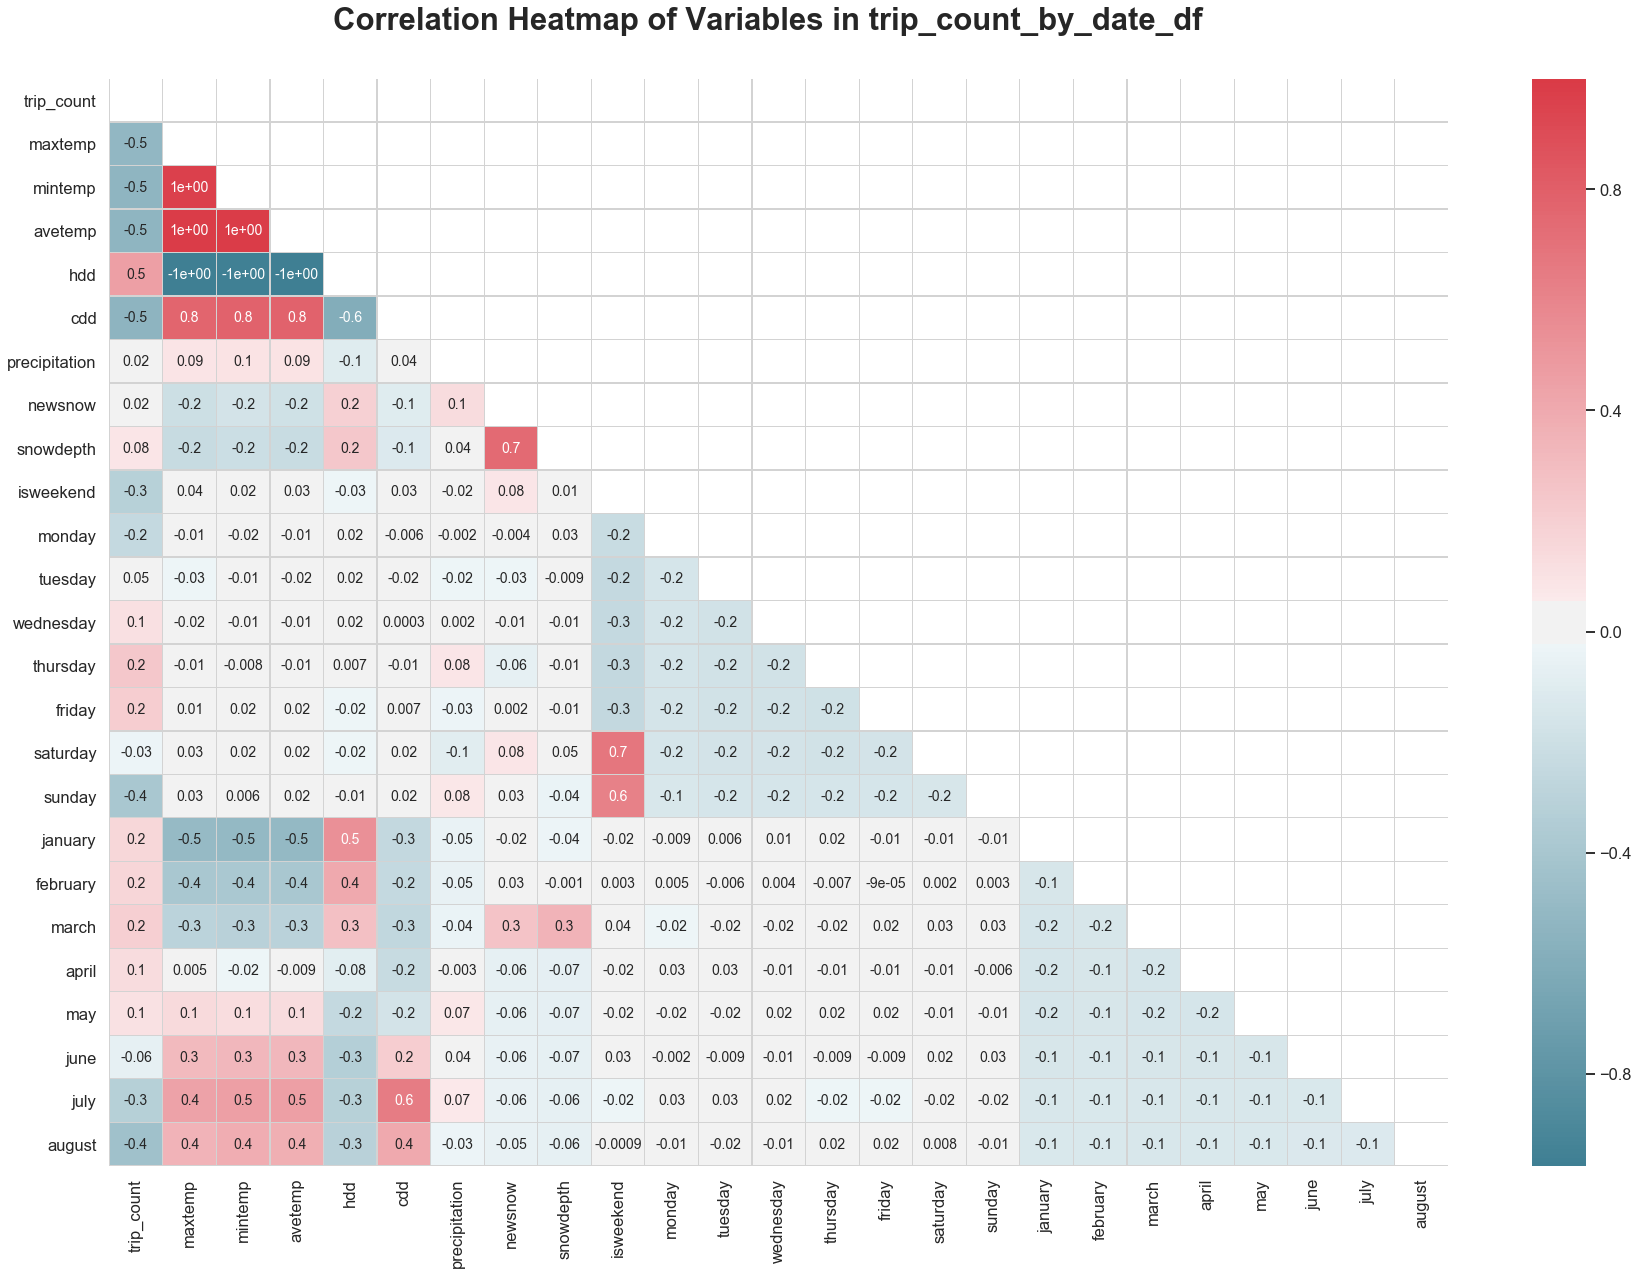

In [12]:
#plotting correlation heatmap for "trip_count_by_date_df"
corr=trip_counts_df.drop(columns=["pickup_dayofweek", "pickup_month"]).corr()
plt.figure(figsize=(30, 20))
mask = np.tril(trip_counts_df.corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,annot_kws={"fontsize":14},fmt = '.1',  cmap=sns.diverging_palette(220, 10, as_cmap=True),  mask = mask, linewidths=0.2, linecolor='lightgray')

#fix for seaborn bug where top and bottom boxes are cut off (adapted from https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.suptitle("Correlation Heatmap of Variables in trip_count_by_date_df", fontweight="bold", fontsize="xx-large", x=0.43, y=0.93)
plt.show()

Looking on the heatmap above, the explanatory variables that are noticeably correlated with `trip_count` are:
- Weather variables (`maxtemp`, `mintemp`, `avetemp`, `hdd` and `cdd`)


- Date-related variables, including `isweekend`, day of week dummies (`monday` to `sunday`) and month of 2019 dummies (`january` to `august`)

Contrary to our expectation that rainy or snowy weather would increase taxi ridership (by reducing the favorability of transport options like biking or walking), precipitation and snowfall have only negligible correlations with `trip_count`. 

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and daily taxi ridership. 

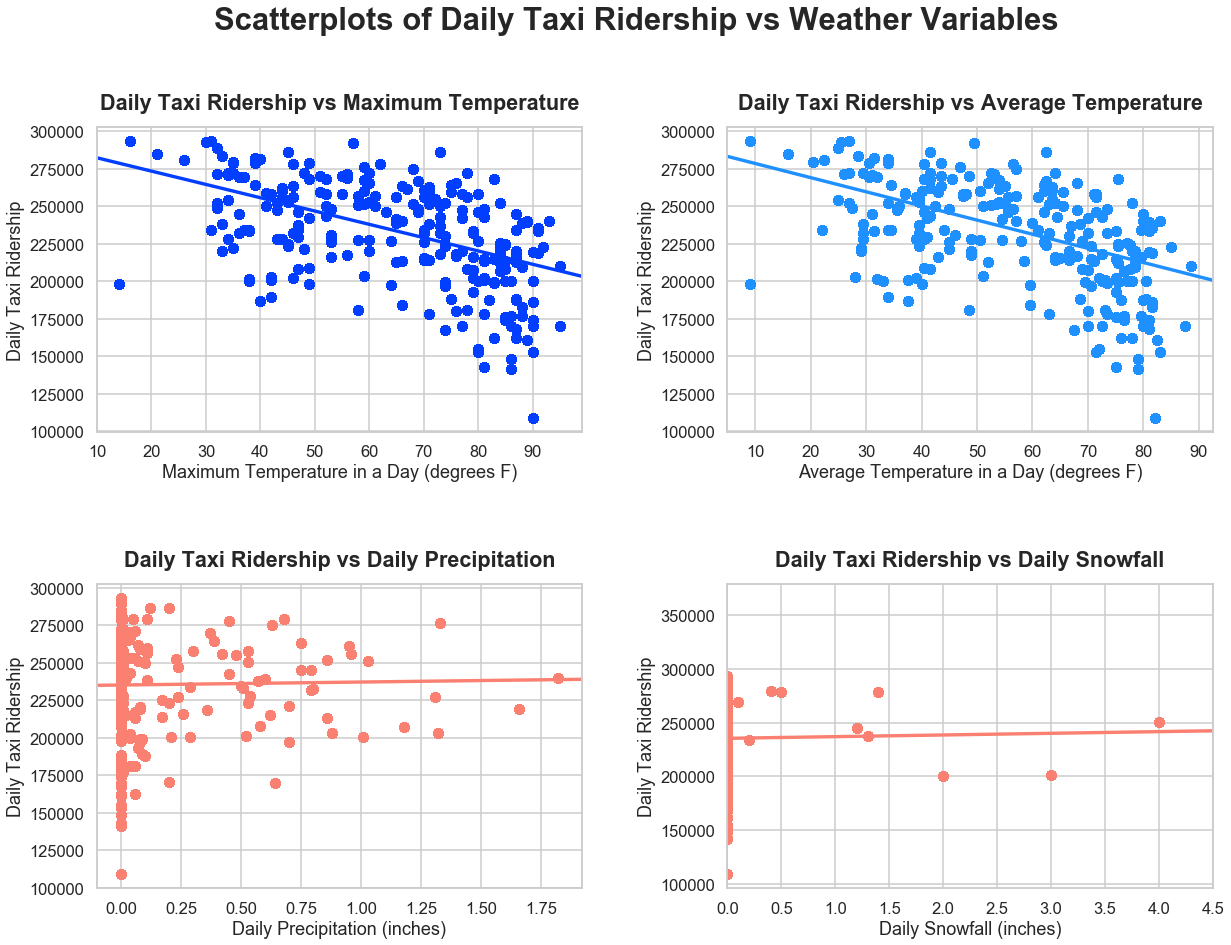

In [13]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

# plotting regression plot of daily taxi ridership vs maximum temperature
sns.regplot(trip_counts_df["maxtemp"],trip_counts_df["trip_count"], ax=axes[0,0]).set(ylabel='Daily Taxi Ridership', xlabel="Maximum Temperature in a Day (degrees F)")
axes[0,0].set_yticklabels((axes[0,0].get_yticks() * 1/0.002).astype(int))
axes[0,0].set_title("Daily Taxi Ridership vs Maximum Temperature", fontweight="bold", fontsize="large", y=1.04)

# plotting regression plot of daily taxi ridership vs average temperature
sns.regplot(trip_counts_df["avetemp"],trip_counts_df["trip_count"], ax=axes[0,1], color="dodgerblue").set(ylabel='Daily Taxi Ridership', xlabel="Average Temperature in a Day (degrees F)")
axes[0,1].set_yticklabels((axes[0,1].get_yticks() * 1/0.002).astype(int))
axes[0,1].set_title("Daily Taxi Ridership vs Average Temperature", fontweight="bold", fontsize="large", y=1.04)

# plotting regression plot of daily taxi ridership vs daily precipitation
sns.regplot(trip_counts_df["precipitation"],trip_counts_df["trip_count"], ax=axes[1,0], color="salmon").set(ylabel='Daily Taxi Ridership', xlabel="Daily Precipitation (inches)")
axes[1,0].set_yticklabels((axes[1,0].get_yticks() * 1/0.002).astype(int))
axes[1,0].set_title("Daily Taxi Ridership vs Daily Precipitation", fontweight="bold", fontsize="large", y=1.04)

# plotting regression plot of daily taxi ridership vs daily snowfall
sns.regplot(trip_counts_df["newsnow"],trip_counts_df["trip_count"], ax=axes[1,1], color="salmon").set(ylabel='Daily Taxi Ridership', xlabel="Daily Snowfall (inches)")
axes[1,1].set_xlim(0,max(trip_counts_df["newsnow"])+0.5)
axes[1,1].set_yticklabels((axes[1,1].get_yticks() * 1/0.002).astype(int))
axes[1,1].set_title("Daily Taxi Ridership vs Daily Snowfall", fontweight="bold", fontsize="large", y=1.04)

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.suptitle("Scatterplots of Daily Taxi Ridership vs Weather Variables", fontweight="bold", fontsize="xx-large", y=1)

plt.show()



The top two scatterplots show that both maximum temperature (a proxy of daytime temperature) and average temperature are negatively correlated to daily taxi ridership. With an increase in maximum or average temperature, especially above the 60-degree mark, New Yorkers rely less on taxis. Perhaps, they turn to other forms of transportation such as walking or riding Citi Bikes that are much more pleasurable without the bitter cold. 

Though `precipitation` appeared uncorrelated in the correlation heatmap, the bottom left scatterplot shows that precipitation is still related to taxi ridership. Low precipitation levels do not guarantee low daily taxi ridership (as evidenced by the high trip counts occurring on 0-precipitation days), but high precipitation levels are always accompanied by at least a moderate level of taxi ridership. 

Likewise, for daily snowfall, high snowfall days always have at least an moderate level of taxi ridership, but days with low or no snowfall have trip counts spanning the spectrum of low to high. Perhaps, the weak and ambiguous relationship between `newsnow` and `trip_counts` is due to the very few data points for snowy days (10 out of 243 days). 

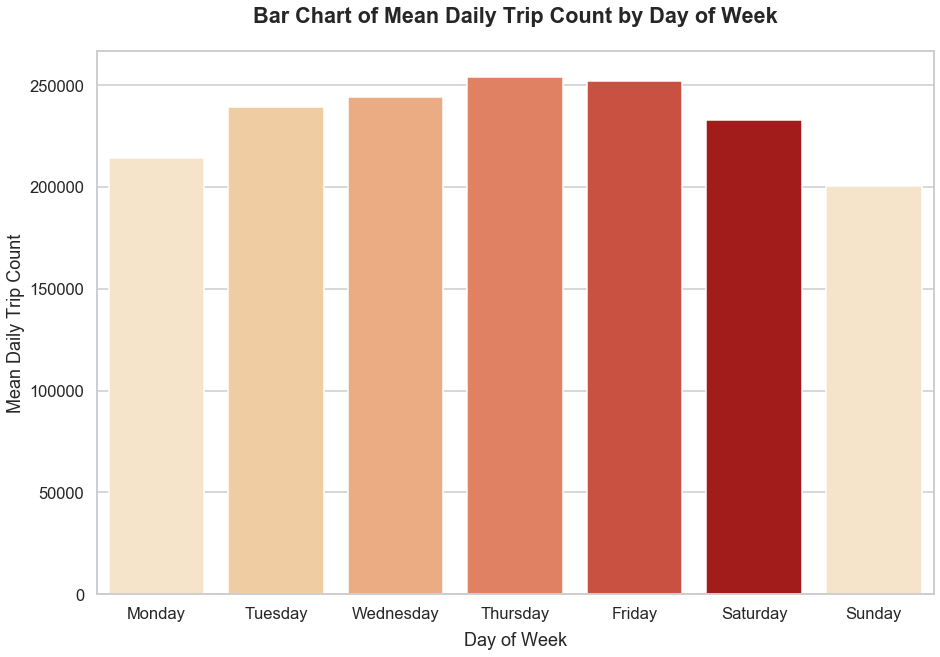

In [14]:
# plotting bar chart of mean daily trip count by day of week
plt.figure(figsize=(15,10))
ax=sns.barplot(trip_counts_df["pickup_dayofweek"], trip_counts_df["trip_count"], ci=None, palette=sns.color_palette("OrRd"))
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
ax.set_ylabel('Mean Daily Trip Count')
ax.set_xlabel('Day of Week', labelpad=10)
plt.title("Bar Chart of Mean Daily Trip Count by Day of Week", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Having deduced weekly seasonality from the time series previously, we would now like to analyze how taxi ridership actually rises and falls within a week. 

Across the days of a week, the mean daily trip count is lowest on Sunday, which is reasonable as taxi commutes to work or afterwork events do not occur on a rest day. Saturday has a higher mean trip count that Sunday, perhaps as it is only a partial rest day for some employees and many Friday night party-goers would ride taxis home on early Saturday morning. 

After Sunday, taxi ridership climbs day-by-day to reach its peak on Thursday, before falling as the weekend arrives. 

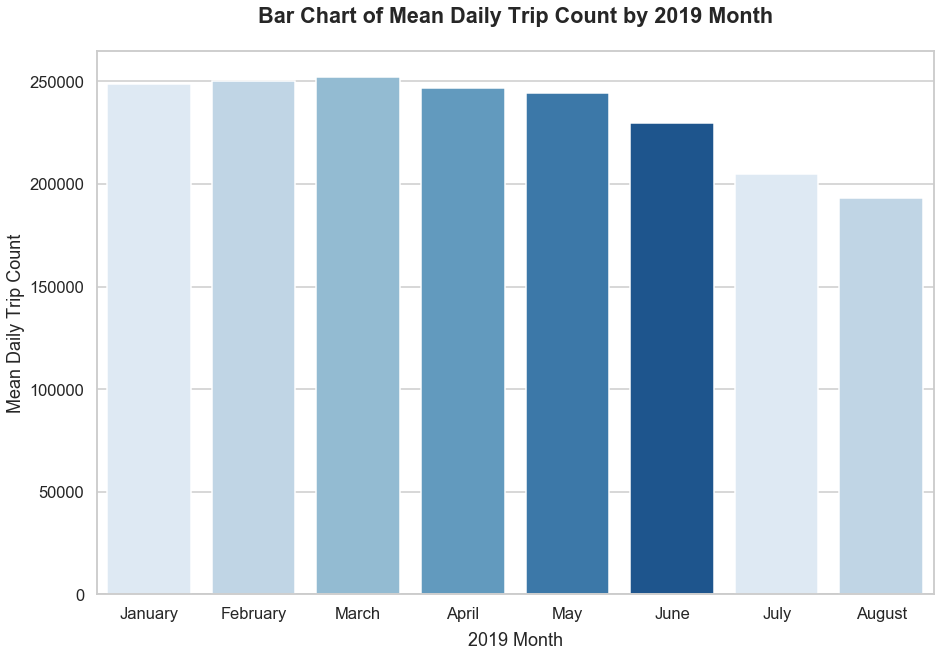

In [15]:
# plotting bar chart of mean daily trip count by 2019 month
plt.figure(figsize=(15,10))
ax=sns.barplot(trip_counts_df["pickup_month"], trip_counts_df["trip_count"], ci=None, palette=sns.color_palette("Blues"))
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
ax.set_ylabel('Mean Daily Trip Count')
ax.set_xlabel('2019 Month', labelpad=10)
plt.title("Bar Chart of Mean Daily Trip Count by 2019 Month", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Echoing the trend of monthly decrease in the time series plot, the mean daily trip count over the 2019 months seems to have fallen at an exponential rate before tapering off at a low in August. 

This also agrees with what we see in the earlier correlation heatmap&mdash; that January 2019 had a 0.2 positive correlation with `trip_counts`, and this correlation fell exponentially over the months to reach -0.4 in August 2019. 

## 4.4 Linear Regression

### 4.4.1 Building the Model

We will use the Akaike’s Information Criterion (AIC) to select a linear regression model with the best relative quality—the best balance between goodness of fit and complexity. 

In [16]:
# defining minAIC_OLS function, with code adapted from ORIE 3120 class (taught by Prof Madeleine Udell)
def minAIC_OLS(X,y):
    variables = X.columns
    model = sm.OLS(y,X[variables]).fit()
    while True:
        print(f'old model aic: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        newmodel = sm.OLS(y,X[newvariables]).fit()
        print(f'new model aic: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables

# selecting columns from dataset and adding constant
linear_model_cols=["maxtemp","avetemp", "precipitation","hdd","cdd","newsnow","snowdepth","tuesday","wednesday","thursday","friday","saturday","sunday","february","march","april","may","june","july","august"]
X=trip_counts_df[linear_model_cols]
X = sm.add_constant(X)
print(f"Initial Variables are {np.array(X.columns)}\n")
y=trip_counts_df["trip_count"]
new_linear_model , linear_variables = minAIC_OLS(X,y)

# fitting linear regression model
new_linear_model = sm.OLS(y,X[linear_variables]).fit()
print(f"After Optimization, New model AIC is {new_linear_model.aic}\n")
print(f"After Optimization, New Variables are {np.array(new_linear_model.params.index)}")

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Initial Variables are ['const' 'maxtemp' 'avetemp' 'precipitation' 'hdd' 'cdd' 'newsnow'
 'snowdepth' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday'
 'february' 'march' 'april' 'may' 'june' 'july' 'august']

old model aic: 1114688.8061268884
new model aic: 1114695.4727836596
After Optimization, New model AIC is 1114688.8061268884

After Optimization, New Variables are ['const' 'maxtemp' 'avetemp' 'precipitation' 'hdd' 'cdd' 'newsnow'
 'snowdepth' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday'
 'february' 'march' 'april' 'may' 'june' 'july' 'august']


As the AIC cannot be reduced by removing any variables, our current linear model achieves the best fit (without overfitting) with the set of explanatory variables fed to it. Notice that we omitted the `monday` and `january` dummy variables to avoid over-parameterizing our model. 

In [17]:
# showing results of linear regression model
results = new_linear_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             trip_count   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                 1.418e+04
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        00:09:05   Log-Likelihood:            -5.5732e+05
No. Observations:              111953   AIC:                         1.115e+06
Df Residuals:                  111932   BIC:                         1.115e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1522.4144     28.227     53.935      0.000    1467.091    1577.738
maxtemp           1.0929      0.046     23.971      0.000       1.004       1.182
avetemp         -18.7480      0.442    -42.405      0.000     -19.615     -17.881
precipitation    18.3141      0.349     52.535      0.000      17.631      18.997
hdd             -15.6852      0.436    -35.999      0.000     -16.539     -14.831
cdd              16.9667      0.435     39.034      0.000      16.115      17.819
newsnow         -14.9317      0.430    -34.712      0.000     -15.775     -14.089
snowdepth         1.1615      0.395      2.944      0.003       0.388       1.935
tuesday          50.4497      0.402    125.433      0.000      49.661      51.238
wednesday        58.8955      0.402    146.367      0.000      58.107      59.684
thursday         79.0887      0.399    198.317      0.000      78.307      79.870
friday           78.8270      0.400    196.858      0.000      78.042      79.612
saturday         41.5529      0.409    101.486      0.000      40.750      42.355
sunday          -27.4379      0.427    -64.285      0.000     -28.274     -26.601
february         13.8534      0.420     33.000      0.000      13.031      14.676
march            31.8380      0.455     69.949      0.000      30.946      32.730
april            41.6487      0.560     74.359      0.000      40.551      42.747
may              44.3001      0.636     69.706      0.000      43.055      45.546
june             32.4594      0.749     43.343      0.000      30.992      33.927
july            -13.1823      0.916    -14.398      0.000     -14.977     -11.388
august          -42.2601      0.829    -50.978      0.000     -43.885     -40.635
==============================================================================
Omnibus:                    31830.830   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115334.111
Skew:                          -1.404   Prob(JB):                         0.00
Kurtosis:                       7.103   Cond. No.                     2.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.4.2 Evaluation of Significance

Performing the joint F-test at the 5% significance level, we see that the F statistic's p-value is 0. Hence, we reject the null hypothesis that none of the explanatory variables are related to `trip_counts`. In other words, our model fits the data better than an intercept-only model. 

An R-squared value of 0.717 means that 71.7% of the variation in `trip_counts` about its mean can be explained by our current fitted model. Seasonality plays an large role in our model's fit&mdash;if we include only day of week dummies, our R-squared is lower at 0.621; if we exclude both day of week and month dummies, our R-squared falls to 0.341. 

Using a two-tailed t-test at a 5% significant level, we reject the null hypothesis that a variable's coefficient is 0 if its upper-tail p-value is below 0.025. All the explanatory variables have p-values of 0 (<0.025) and are thus significant.  

To draw meaningful interpretations from the results, we must multiply each coefficient by 1/0.002, as we sampled only 0.002 of all taxi rides in the raw dataset. 

In [18]:
# adjusting coefficients to account for our sampling of dataset by 0.002
scaled_value_coefs=pd.DataFrame(new_linear_model.params*1/0.002)
scaled_value_coefs.rename(columns={0: "Scaled Values"}, inplace=True)
scaled_value_coefs

,Scaled Values
const,761207.216098
maxtemp,546.473821
avetemp,-9374.009961
precipitation,9157.046863
hdd,-7842.604648
cdd,8483.355273
newsnow,-7465.834400
snowdepth,580.730617
tuesday,25224.827561
wednesday,29447.735929


### 4.4.3 Key Findings

Some key findings from the linear regression model include:

- Echoing the negative correlations between temperatures and `trip_count` that we saw earlier, a 1-degree F increase in `avetemp` (average daily temperature) is linked to a drop in daily taxi ridership by 9,374 rides, when covariates are held constant. An increase in `maxtemp` is linked to a surprising increase in daily trip counts, suggesting that the negative correlations we observed earlier for `maxtemp` could be due to its interaction with `avetemp`. 


- A 1-inch increase in precipitation is linked to an increase of 9,157 daily trip counts, holding covariates constant, suggesting that more rain indeed spurs taxi commutes. There is a interesting relationship observed in snowfall, however. A 1-inch increase in `newsnow` (new daily snowfall) is associated with 7466 fewer daily rides, when covariates are held constant. It is possible that new snowfall affects the safety of roads and clogs up traffic, thus deterring people from commuting via taxi. `snowdepth` (accumulated snow) has a converse effect of increasing daily ridership slightly, which makes sense as snow accumulations from previous days do not clog up traffic, and may encourage people to commute by taxi instead of walking or biking. 


- Day of week has an important effect on `trip_count`. In a week in January, Sunday is linked to a decrease in daily trip counts by 13,719 rides, relative to a Monday. Thursday and Friday are linked to the largest increases in taxi ridership as compared to Monday, which matches the intuition we got in the bar chart earlier. Overall, we can see an day-by-day increase in taxi ridership from Monday through Friday, before a sharp drop in taxi ridership on Saturday and a sharper drop on Sunday. 


- Month has an outsize relationship with daily taxi ridership. When covariates are held constant, February has 6,927 more daily rides than January (on a Monday), and daily taxi ridership continues to increase (in comparison to January) to reach a peak in May of 22,150 rides more than in January. It then falls drastically in the next 3 months such that August has 21,130 fewer daily rides than January. Interestingly, the exponential month-on-month decrease in daily rides that we gleaned from the bar chart and correlation matrix earlier no longer exists when we hold covariates constant. 

### 4.4.4 Evaluation of the Model

For us to be able to draw valid inferences, the linear regression model has to satisfy four assumptions: 

1. Model is linear in the predictors
2. Residuals have a constant variance (are homoskedastic)
3. Residuals are mutually independent
4. Residuals are normally distributed

We will test each of the assumptions above. 

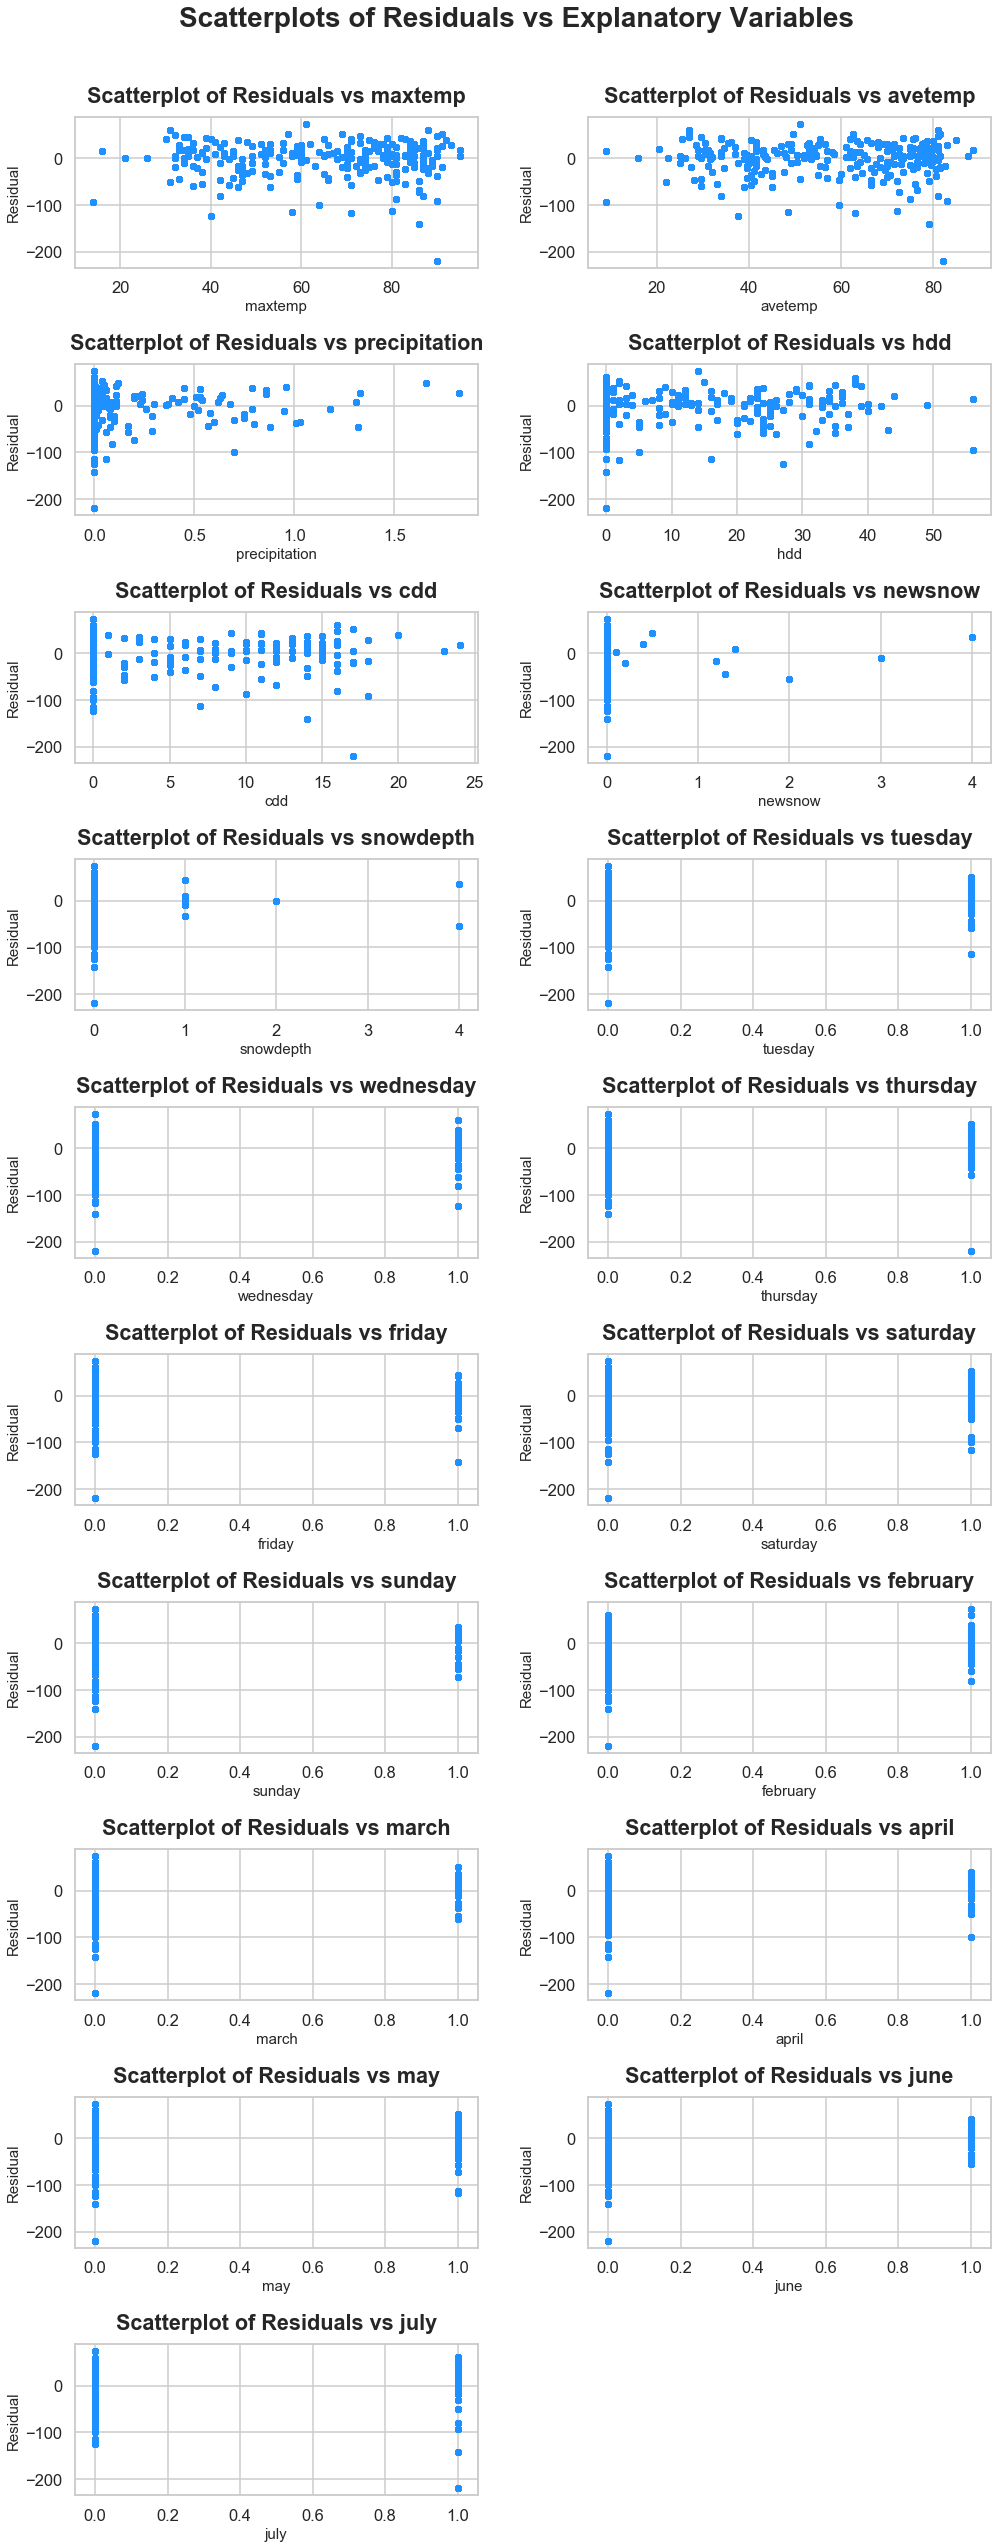

In [19]:
# getting the residuals of the linear model
res=new_linear_model.resid
f, ax = plt.subplots(nrows=10, ncols=2, figsize=(15,35))
f.delaxes(ax[9,1])
f.tight_layout(pad=3, h_pad=3.5)

# plotting scatterplots of residuals vs each of the explanatory variables
for c, colname in enumerate(linear_model_cols):
    rowindex = c//2
    colindex = 0 if c%2==0 else 1
    ax[rowindex][colindex].scatter(trip_counts_df[f"{colname}"],res, color="dodgerblue", marker=".")
    ax[rowindex][colindex].set_title(f"Scatterplot of Residuals vs {colname}", fontweight="bold", fontsize="large", pad=15)
    ax[rowindex][colindex].set_ylabel("Residual", fontsize=15)
    ax[rowindex][colindex].set_xlabel(f"{colname}", fontsize=15)
    f.suptitle('Scatterplots of Residuals vs Explanatory Variables', fontsize="28", fontweight="bold", y=1.02)
plt.show()

*1st Assumption Satisfied:* Since the average values of the residuals do not depend on the values of each explanatory variable, our model is indeed linear in its predictors. 

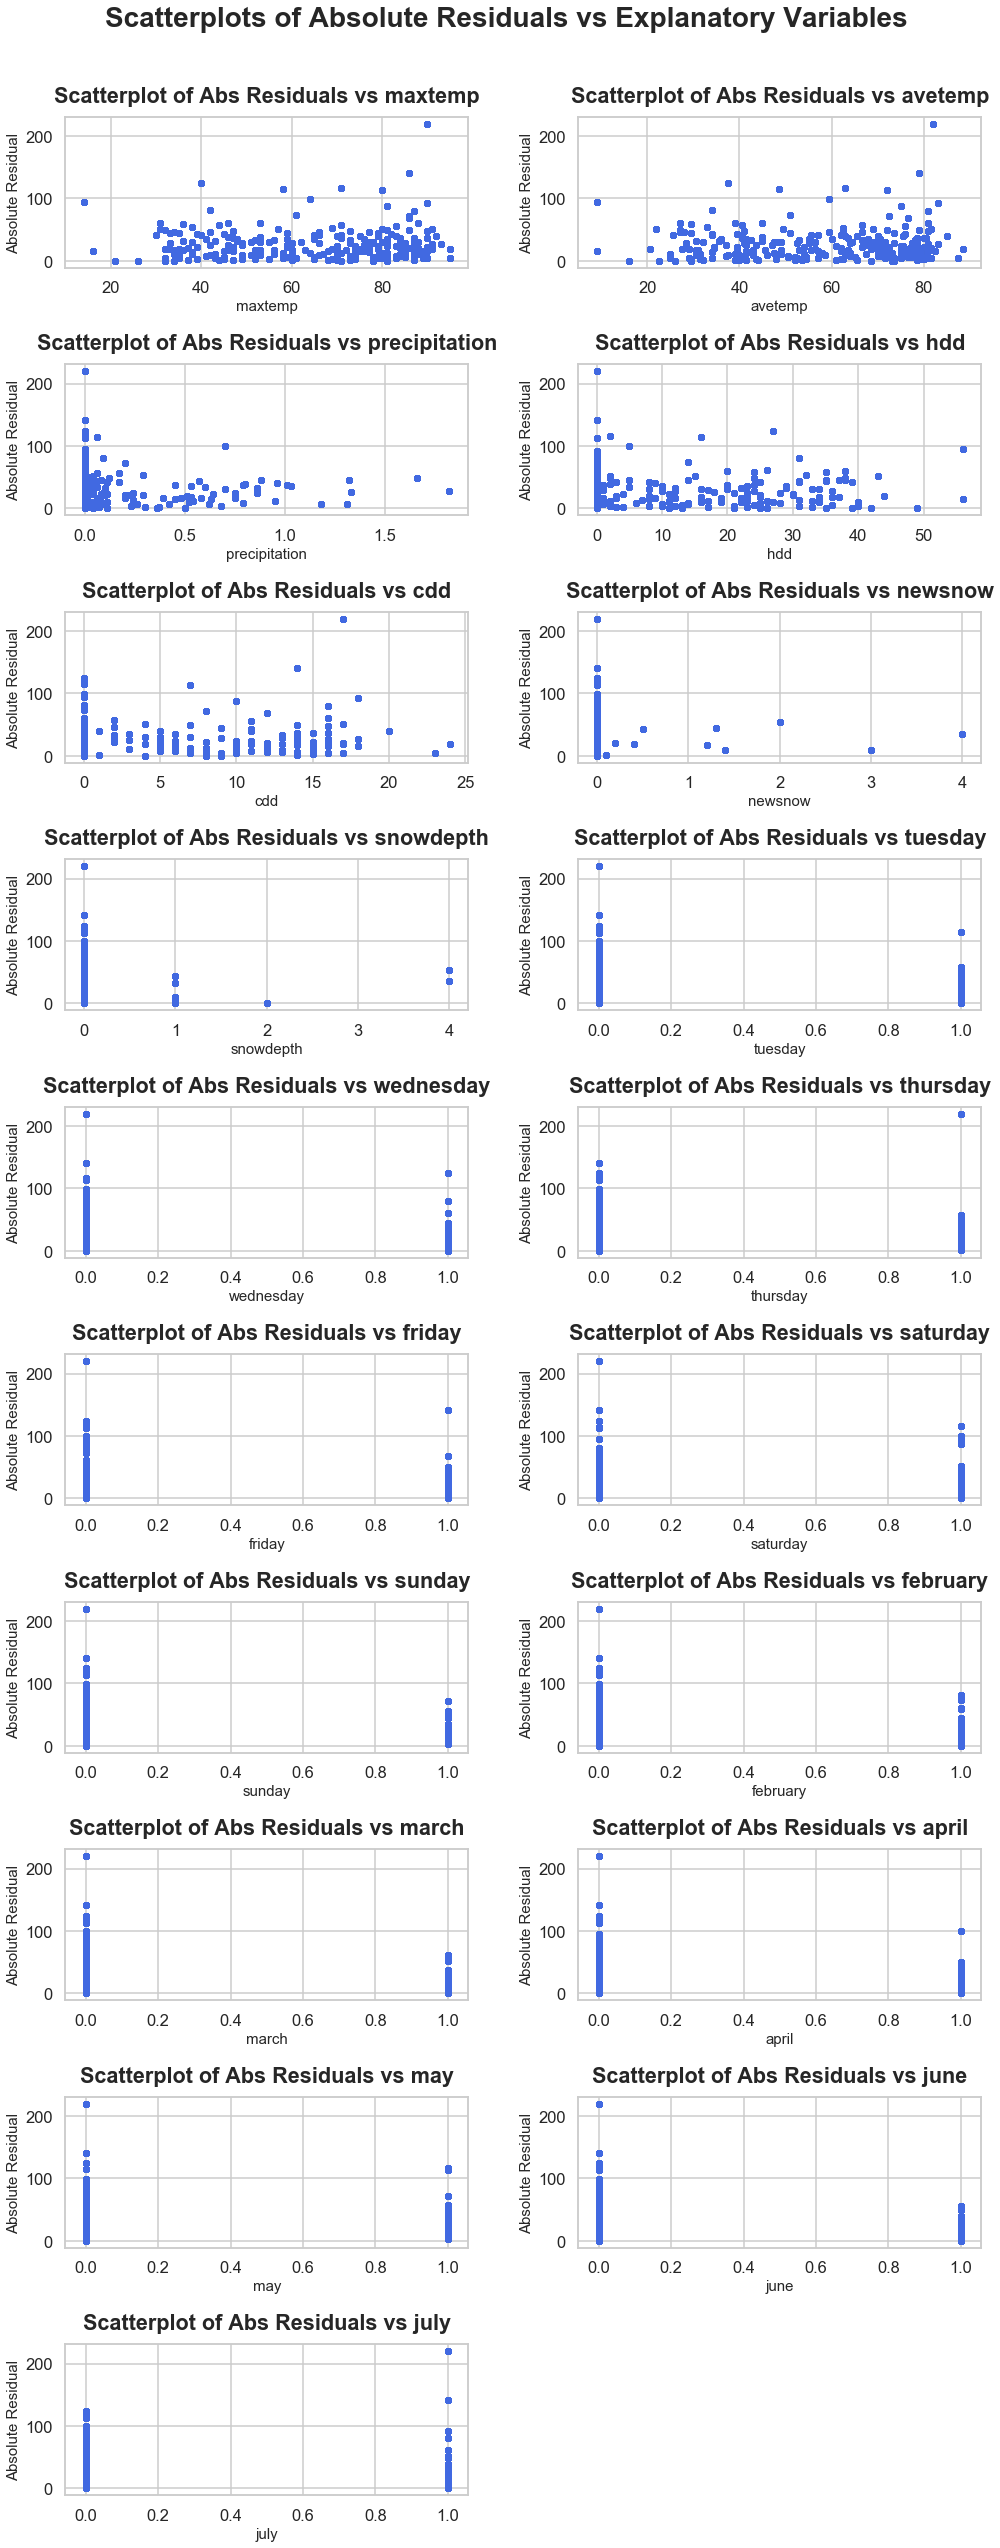

In [20]:
# getting the absolute residuals of the linear model
abs_res=np.abs(np.array(res))
f, ax = plt.subplots(nrows=10, ncols=2, figsize=(15,35))
f.delaxes(ax[9,1])
f.tight_layout(pad=3, h_pad=3.5)

# plotting scatterplots of absolute residuals vs each of the explanatory variables
for c, colname in enumerate(linear_model_cols):
    rowindex = c//2
    colindex = 0 if c%2==0 else 1
    ax[rowindex][colindex].scatter(trip_counts_df[f"{colname}"],abs_res, color="royalblue", marker=".")
    ax[rowindex][colindex].set_title(f"Scatterplot of Abs Residuals vs {colname}", fontweight="bold", fontsize="large", pad=15)
    ax[rowindex][colindex].set_ylabel("Absolute Residual", fontsize=15)
    ax[rowindex][colindex].set_xlabel(f"{colname}", fontsize=15)
    f.suptitle('Scatterplots of Absolute Residuals vs Explanatory Variables', fontsize="28", fontweight="bold", y=1.02)
plt.show()

*2nd Assumption Satisfied:* Since the distribution of absolute residuals does not depend on value of each explanatory variable, the variance of the residuals is constant. 

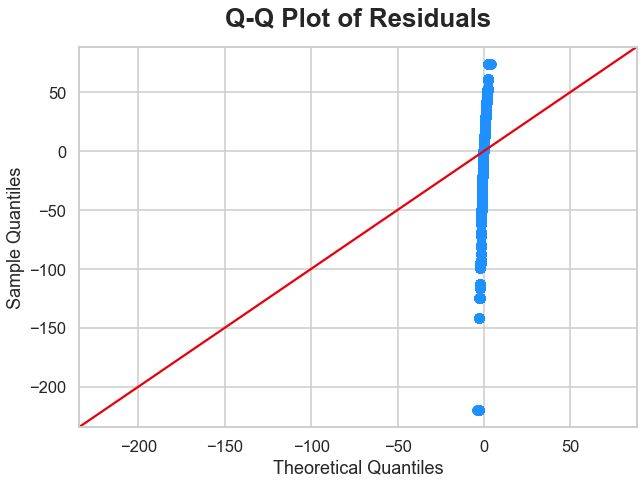

In [21]:
# plotting a QQ-plot of residuals
f, ax = plt.subplots(figsize=(10,7))
fig = sm.qqplot(res, line="45",ax=ax, color="dodgerblue")
ax.set_title("Q-Q Plot of Residuals", fontweight="bold", fontsize="x-large", y=1.04)
plt.show()

*3rd Assumption Not Satisfied:* Since the Q-Q plot of the residuals does not yield a straight 45-degree line, the residuals are not normally distributed.

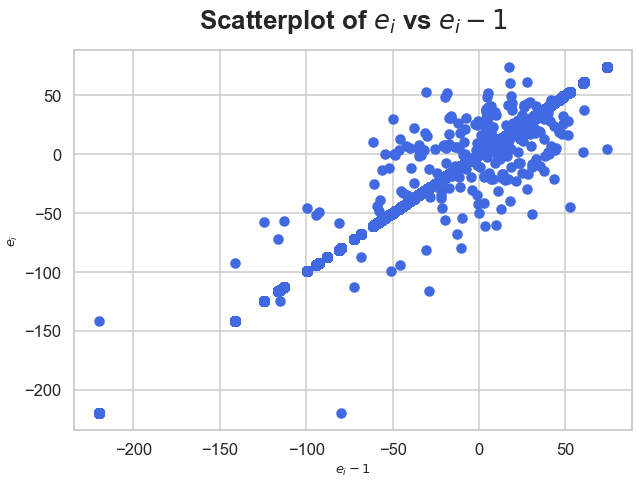

In [22]:
res=new_linear_model.resid

# plotting a scatterplot of consecutive residuals
plt.figure(figsize=(10,7))
plt.scatter(res[:-1], res[1:], color="royalblue")
plt.title("Scatterplot of $e_i$ vs $e_i-1$", fontweight="bold", fontsize="x-large", y=1.04)
plt.ylabel("$e_i$", fontsize=13)
plt.xlabel("$e_i-1$", fontsize=13)
plt.show()

*4th Assumption Not Satisfied:* Since there is a clear relationship between consecutive residuals (positive linear relationship), residuals are not mutually independent. This is most likely due to the vulnerability of time series regression models to serial correlation (read more at http://people.duke.edu/~rnau/testing.htm). 

Overall, given that our linear model violates the assumptions of normal and mutually independent residuals, we would not proceed to predict `trip_counts` using it. The predictions that it generates could potentially be biased or misleading. 

# 5. Zooming into Manhattan: Which Variables are Best for Predicting the Odds of a Downtown Pickup/Dropoff for Manhattan Rides?

## 5.1 Laying the Foundations

Now, we will dive into the question of which variables can help us predict the odds of a Manhattan taxi ride having a downtown pickup/dropoff location. For this part, we will create several new variables:
- `is_downtown`: a binary variable that codes whether a ride has a downtown pickup/dropoff location *(1: yes, 0: no)*


- `PUtime_of_day`: a variable that describes the time of day of a ride pickup *(early morning: 3am-7am, morning rush hour: 7am-11am, lunchtime: 11am-3pm, evening rush hour: 3pm-7pm, late evening: 7pm-11pm, late night: 11pm-3am)*


- `DOtime_of_day`: a variable that describes the time of day of a ride dropoff *(early morning: 3am-7am, morning rush hour: 7am-11am, lunchtime: 11am-3pm, evening rush hour: 3pm-7pm, late evening: 7pm-11pm, late night: 11pm-3am)*


- 6 dummy variables for pickup time of day (`pickup_early_morning`, `pickup_morning_rush_hour`, `pickup_lunchtime`, `pickup_evening_rush_hour`,`pickup_late_evening` and `pickup_late_night`)


- 6 dummy variables for pickup time of day (`dropoff_early_morning`, `dropoff_morning_rush_hour`, `dropoff_lunchtime`, `dropoff_evening_rush_hour`,`dropoff_late_evening` and `dropoff_late_night`)

Before we start, we will import the taxi zone lookup table (adapted from https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv). This table maps pickup/dropoff location IDs to named locations in Manhattan, which we classified into 4 zones:

- Uptown: above 59th Street


- Midtown: 34th-59th Street


- Lower-Midtown: 14th-33rd Street


- Downtown: below 14th Street


We will also create a new dataframe with Manhattan-only rides and perform some data manipulation to ready it for logistic regression. 

In [23]:
isweekend_df=isweekend_df.drop_duplicates()

#importing taxi zone lookup dataset that has been preprocessed and tagged with Manhattan zones (Uptown, Midtown, Lower-Midtown, Downtown)
taxi_zone_lookup_df = pd.read_csv("taxi_zone_lookup.csv")

#merging isweekend_df with taxi_zone_lookup_df
lagg_df=isweekend_df.merge(taxi_zone_lookup_df,how="left",left_on=isweekend_df["PULocationID"], right_on=taxi_zone_lookup_df["LocationID"])
lagg_df.rename(columns={"Borough":"PUborough","Zone":"PUzone","service_zone":"PUservice_zone","manhattan_zone":"PUmanhattan_zone"},inplace=True)
lagg_df.drop(columns=["key_0","LocationID"],inplace=True)
lagg_df=lagg_df.merge(taxi_zone_lookup_df,how="left",left_on=lagg_df["DOLocationID"], right_on=taxi_zone_lookup_df["LocationID"])
lagg_df.rename(columns={"Borough":"DOborough","Zone":"DOzone","service_zone":"DOservice_zone","manhattan_zone":"DOmanhattan_zone"},inplace=True)
lagg_df.drop(columns=["key_0","LocationID"],inplace=True)


#categorizing time of day into 6 names (early morning, morning rush hour, lunchtime, evening rush hour, late evening, late night)
lagg_df["PUtime_of_day"]=pd.to_datetime(lagg_df['pickup_datetime']).dt.hour
lagg_df.replace({"PUtime_of_day": {3:"early morning",4:"early morning",5:"early morning",6:"early morning",7:"morning rush hour",8:"morning rush hour",9:"morning rush hour",10:"morning rush hour",11:"lunchtime",12:"lunchtime",13:"lunchtime",14:"lunchtime",15:"evening rush hour",16:"evening rush hour",17:"evening rush hour",18:"evening rush hour",19:"late evening",20:"late evening",21:"late evening",22:"late evening", 23:"late night",0:"late night",1:"late night",2:"late night"}}, inplace=True)
lagg_df["DOtime_of_day"]=pd.to_datetime(lagg_df['dropoff_datetime']).dt.hour
lagg_df.replace({"DOtime_of_day": {3:"early morning",4:"early morning",5:"early morning",6:"early morning",7:"morning rush hour",8:"morning rush hour",9:"morning rush hour",10:"morning rush hour",11:"lunchtime",12:"lunchtime",13:"lunchtime",14:"lunchtime",15:"evening rush hour",16:"evening rush hour",17:"evening rush hour",18:"evening rush hour",19:"late evening",20:"late evening",21:"late evening",22:"late evening", 23:"late night",0:"late night",1:"late night",2:"late night"}}, inplace=True)

#creating two datasets: one for taxi rides with Manhattan pickups and the other for taxi rides with Manhattan dropoffs
pu_manhattan_df=lagg_df[~pd.isnull(lagg_df["PUmanhattan_zone"])]
do_manhattan_df=lagg_df[~pd.isnull(lagg_df["DOmanhattan_zone"])]

#creating a larger dataset for taxi rides with Manhattan pickups or dropoffs
manhattan_df=lagg_df[~pd.isnull(lagg_df["PUmanhattan_zone"])|~pd.isnull(lagg_df["DOmanhattan_zone"])]

#splitting manhattan_df into two datasets based on whether a ride had downtown pickups/dropoffs
PUDO_downtown_y_df=manhattan_df[(manhattan_df["PUmanhattan_zone"]=="Downtown") | (manhattan_df["DOmanhattan_zone"]=="Downtown")]
PUDO_downtown_n_df=manhattan_df[(manhattan_df["PUmanhattan_zone"]!="Downtown") & (manhattan_df["DOmanhattan_zone"]!="Downtown")]

#creating an is_downtown column to code downtown/non-downtown rides
manhattan_df["is_downtown"]=np.where((manhattan_df["PUmanhattan_zone"]=="Downtown") | (manhattan_df["DOmanhattan_zone"]=="Downtown"),1,0)

#replacing PUtime_of_day with 6 columns of dummy variables
PUtimeofday_dummies=pd.get_dummies(manhattan_df["PUtime_of_day"])
manhattan_df=manhattan_df.join(PUtimeofday_dummies)
manhattan_df.rename(columns={"early morning":"pickup_early_morning", "morning rush hour":"pickup_morning_rush_hour", "lunchtime":"pickup_lunchtime", "evening rush hour":"pickup_evening_rush_hour", "late evening":"pickup_late_evening", "late night":"pickup_late_night"}, inplace=True)

#replacing DOtime_of_day with 6 columns of dummy variables
DOtimeofday_dummies=pd.get_dummies(manhattan_df["DOtime_of_day"])
manhattan_df=manhattan_df.join(DOtimeofday_dummies)
manhattan_df.rename(columns={"early morning":"dropoff_early_morning", "morning rush hour":"dropoff_morning_rush_hour", "lunchtime":"dropoff_lunchtime", "evening rush hour":"dropoff_evening_rush_hour", "late evening":"dropoff_late_evening", "late night":"dropoff_late_night"}, inplace=True)
manhattan_df.drop(columns=["PUtime_of_day","DOtime_of_day"], inplace=True)

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
# creating 6 columns of dummy variables for pickups/dropoffs at a specific time of day
manhattan_df["pickup_dropoff_early_morning"]=np.where((manhattan_df["pickup_early_morning"]==1) | (manhattan_df["dropoff_early_morning"]==1),1,0)
manhattan_df["pickup_dropoff_morning_rush_hour"]=np.where((manhattan_df["pickup_morning_rush_hour"]==1) | (manhattan_df["dropoff_morning_rush_hour"]==1),1,0)
manhattan_df["pickup_dropoff_lunchtime"]=np.where((manhattan_df["pickup_lunchtime"]==1) | (manhattan_df["dropoff_lunchtime"]==1),1,0)
manhattan_df["pickup_dropoff_evening_rush_hour"]=np.where((manhattan_df["pickup_evening_rush_hour"]==1) | (manhattan_df["dropoff_evening_rush_hour"]==1),1,0)
manhattan_df["pickup_dropoff_late_evening"]=np.where((manhattan_df["pickup_late_evening"]==1) | (manhattan_df["dropoff_late_evening"]==1),1,0)
manhattan_df["pickup_dropoff_late_night"]=np.where((manhattan_df["pickup_late_night"]==1) | (manhattan_df["dropoff_late_night"]==1),1,0)

## 5.2 Examining Correlations with `is_downtown` through Visualizations

As a first step, we will run a correlation heatmap to identify the explanatory variables with noticeable correlations with our response variable (`is_downtown`). 

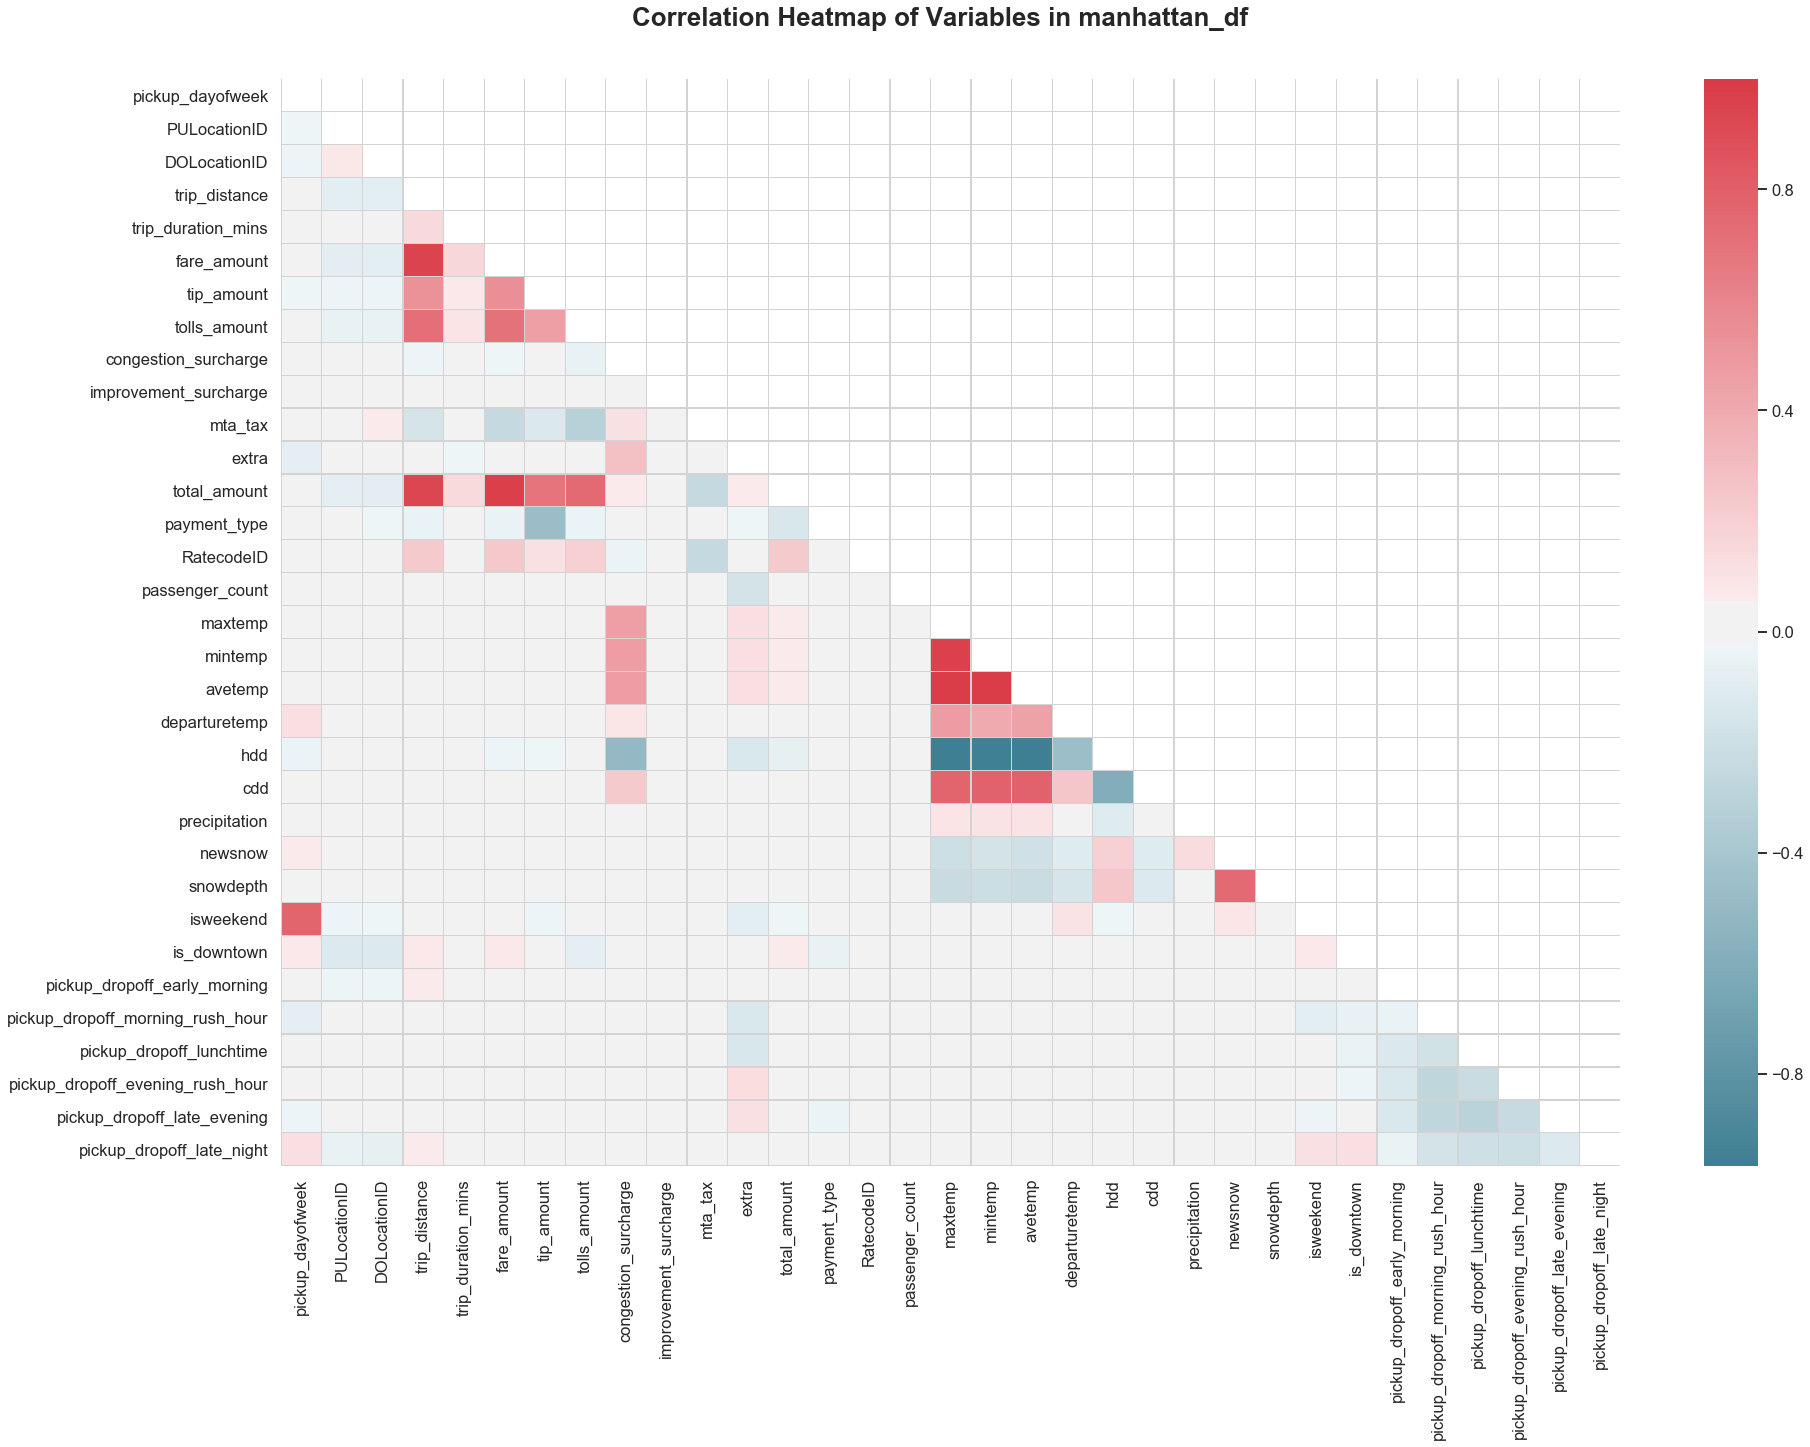

In [25]:
# plotting correlation heatmap of variables in "manhattan_df"
corr=manhattan_df.drop(columns=["pickup_early_morning","pickup_morning_rush_hour","pickup_lunchtime","pickup_evening_rush_hour","pickup_late_evening","pickup_late_night","dropoff_early_morning","dropoff_morning_rush_hour","dropoff_lunchtime","dropoff_evening_rush_hour","dropoff_late_evening","dropoff_late_night"]).corr()
plt.figure(figsize=(30,20))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),  mask = mask, linewidths=0.2, linecolor='lightgray')

# fix for seaborn bug where top and bottom boxes are cut off (adapted from https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.suptitle("Correlation Heatmap of Variables in manhattan_df", fontweight="bold", fontsize="x-large", x=0.43, y=0.93)
plt.show()

Looking on this heatmap, explanatory variables correlated with `is_downtown` include:
- Whether the taxi ride occurred on a weekend (`isweekend`) 
- Time of day (especially `pickup_dropoff_morning_rush_hour`, `pickup_dropoff_lunchtime`, `pickup_dropoff_evening_rush_hour` and `pickup_dropoff_late_night`)
- Amount of payment (`fare_amount`,`tolls_amount` and `total_amount`)
- Distance logged in a taxi ride (`trip_distance`)
- Payment type (`payment_type`)

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and `is_downtown`. 

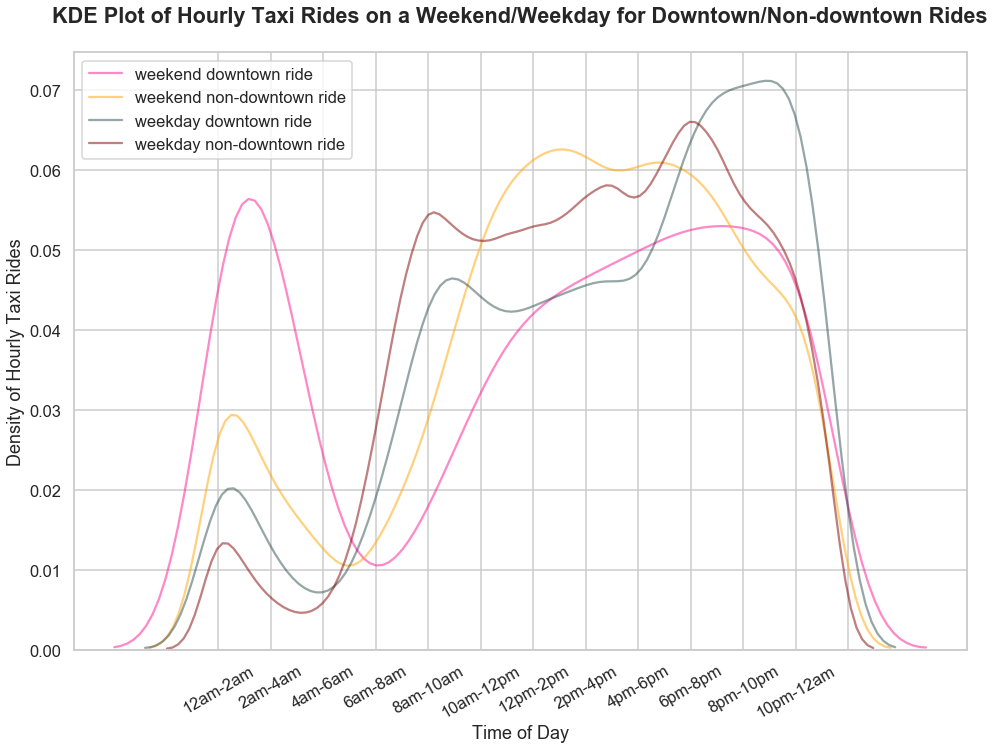

In [26]:
# plotting KDE plot of hourly taxi rides on a weekend/weekday for downtown/non-downtown rides
plt.figure(figsize=(16,11))
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==1) & (manhattan_df["is_downtown"]==1)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend downtown ride", kde_kws={"color":"deeppink", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==1) & (manhattan_df["is_downtown"]==0)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend non-downtown ride", kde_kws={"color":"orange", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==0) & (manhattan_df["is_downtown"]==1)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekday downtown ride", kde_kws={"color":"darkslategray", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==0) & (manhattan_df["is_downtown"]==0)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekday non-downtown ride", kde_kws={"color":"maroon", 'alpha': 0.5})
plt.xticks(np.arange(0,25,2), labels=["12am-2am","2am-4am","4am-6am","6am-8am","8am-10am","10am-12pm","12pm-2pm","2pm-4pm","4pm-6pm","6pm-8pm","8pm-10pm","10pm-12am"], rotation=30)
plt.xlabel("Time of Day")
plt.ylabel("Density of Hourly Taxi Rides")
plt.title("KDE Plot of Hourly Taxi Rides on a Weekend/Weekday for Downtown/Non-downtown Rides", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Using a KDE plot, we discover the following: 
- On late nights (11pm-3am), the density of weekend downtown rides is much higher than that of weekday downtown rides, thus conforming with the correlation heatmap's results. It also makes sense as many late-night parties occur in the downtown area on weekends, drawing more taxi rides to and from downtown on weekends.


- On early mornings (3am-7am), the density of weekend downtown rides is higher than that of weekday downtown rides from 3-5am but dips below the gray line from 5-7am. the "canceling out" of opposite effects may explain why the correlation betwen early mornings and `is_downtown` is negligible. 


- On late evenings (7pm-11pm), the density of downtown rides (gray and pink lines) on average higher than that of non-downtown rides (represented by brown and yellow lines). This suggests that the late evening time window might be a good variable to use to predict `is_downtown` odds. 

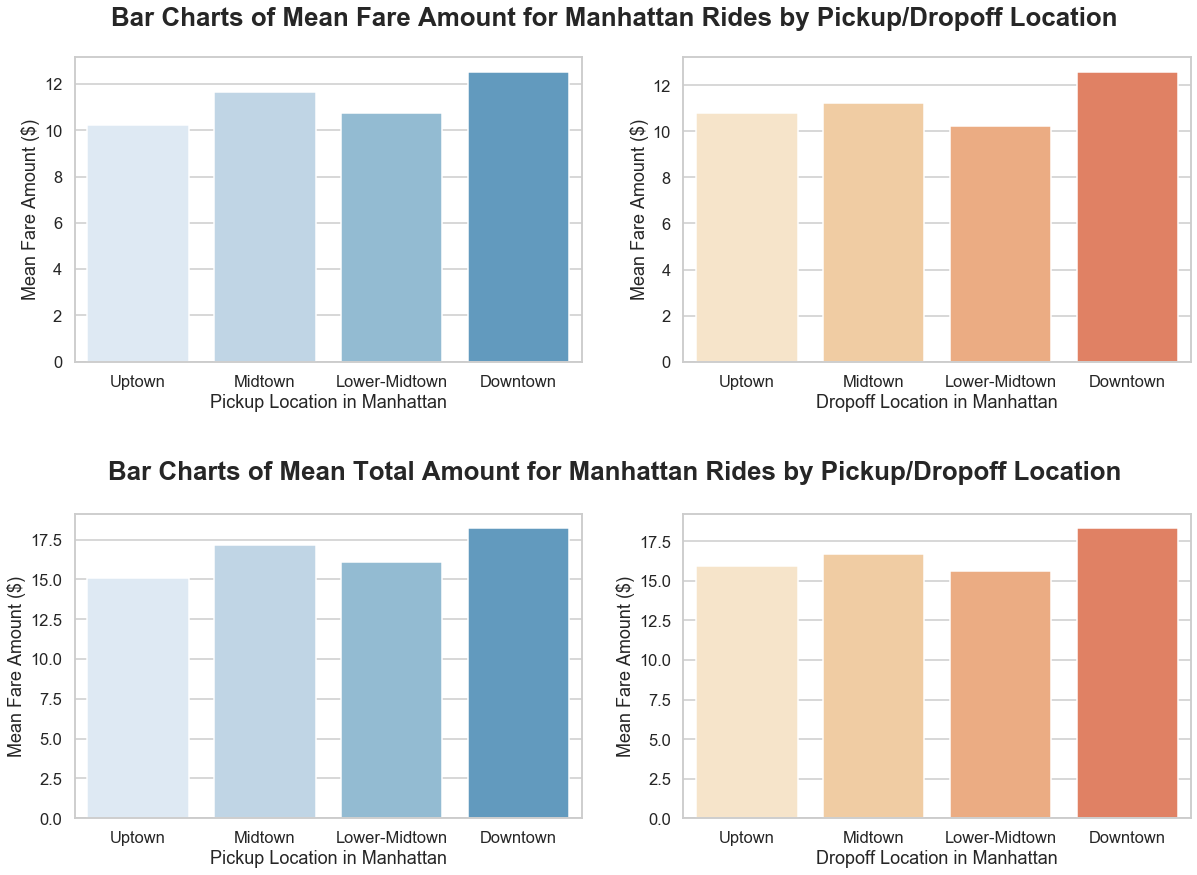

In [27]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

# plotting bar charts of mean fare amount for manhattan rides by pickup/dropoff location
sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["fare_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,0], palette=sns.color_palette("Blues")).set(ylabel='Mean Fare Amount ($)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["fare_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,1],  palette=sns.color_palette("OrRd")).set(ylabel='Mean Fare Amount ($)', xlabel="Dropoff Location in Manhattan")

# plotting bar charts of mean total amount for manhattan rides by pickup/dropoff location
sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["total_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,0], palette=sns.color_palette("Blues")).set(ylabel='Mean Fare Amount ($)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["total_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,1],  palette=sns.color_palette("OrRd")).set(ylabel='Mean Fare Amount ($)', xlabel="Dropoff Location in Manhattan")

plt.figtext(0.5,0.93, "Bar Charts of Mean Fare Amount for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.figtext(0.5,0.48, "Bar Charts of Mean Total Amount for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.subplots_adjust(hspace = 0.5 )

plt.show()

The bar charts above show that for both taxi pickups and dropoffs, the mean fare amount is significantly higher for the downtown area than the non-downtown area, thus echoing the positive correlation between `is_downtown` and `fare_amount`. The mean total amount (which includes fare amount, tip amount and tolls) is similarly higher for downtown rides than non-downtown rides. 

What is the intuition behind the higher mean fares in the downtown area? Fare amount is a influenced by both trip distance (\\$0.50 per 1/5 mile above 12mph) and trip duration (\\$0.50 per 60 seconds in slow traffic). Do downtown trips tend to clock a longer distance, or do they simply take a longer time traversing the same distance (have a lower speed)?

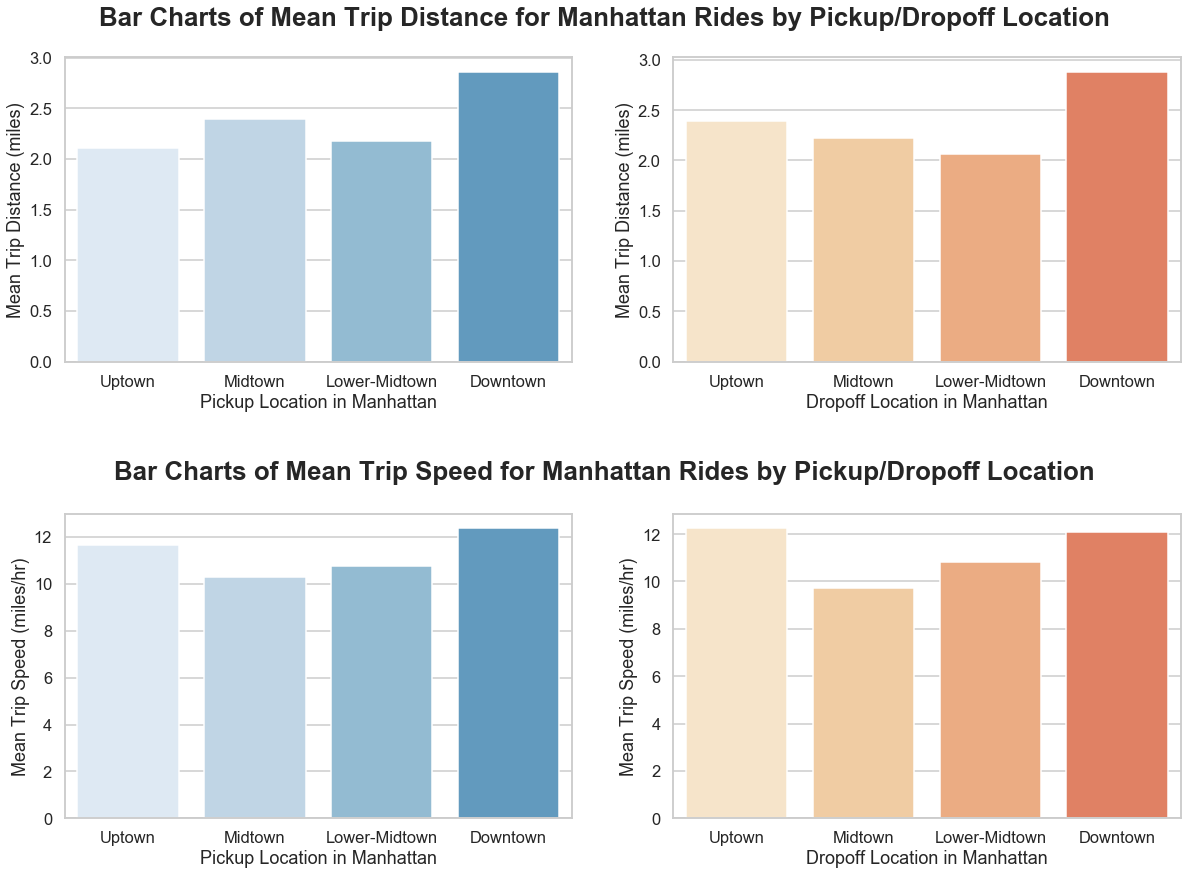

In [28]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

# plotting bar charts of mean trip distance for manhattan rides by pickup/dropoff location
sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["trip_distance"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,0], palette=sns.color_palette("Blues")).set(ylabel='Mean Trip Distance (miles)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["trip_distance"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,1],  palette=sns.color_palette("OrRd")).set(ylabel='Mean Trip Distance (miles)', xlabel="Dropoff Location in Manhattan")

# plotting bar charts of mean trip speed for manhattan rides by pickup/dropoff location
sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["trip_distance"]/pu_manhattan_df["trip_duration_mins"]*60, order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,0], palette=sns.color_palette("Blues")).set(ylabel='Mean Trip Speed (miles/hr)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["trip_distance"]/do_manhattan_df["trip_duration_mins"]*60, order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,1],  palette=sns.color_palette("OrRd")).set(ylabel='Mean Trip Speed (miles/hr)', xlabel="Dropoff Location in Manhattan")

plt.figtext(0.5,0.93, "Bar Charts of Mean Trip Distance for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.figtext(0.5,0.48, "Bar Charts of Mean Trip Speed for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.subplots_adjust(hspace = 0.5 )

plt.show()

It turns out that trip distance is the main factor at play in creating the difference in fare amounts between downtown and non-downtown trips. For downtown rides, the mean trip distance is more than half a mile longer than the mean trips distances of uptown, midtown and lower-midtown rides. This could be due to the heavier reliance of taxis among employees in the downtown financial services industry to commute to and from home (in other Manhattan zones or NYC boroughs). 

The mean speed for downtown rides is actually greater than or equal to the mean speed of non-downtown rides, suggesting that the "\\$0.50 per 60 seconds in slow traffic" component in taxi fares is lower for downtown rides (despite their higher mean fare amounts). 

## 5.3 Logistic Regression

### 5.3.1 Building the Model

As we did for the linear regression model in Section 3.4, we will use the Akaike’s Information Criterion (AIC) to select a logistic regression model with the best relative quality&mdash;the best balance between goodness of fit and complexity. If our interpretations were accurate in Section 4.2, the mix of variables that yield the lowest AIC should largely be the same as those we identified. 

In [29]:
Xcols=["fare_amount", "total_amount", "tip_amount", "tolls_amount","payment_type", "trip_duration_mins", "trip_distance", "passenger_count", "isweekend", "precipitation", "avetemp","maxtemp","pickup_dropoff_early_morning", "pickup_dropoff_morning_rush_hour", "pickup_dropoff_evening_rush_hour", "pickup_dropoff_late_evening", "pickup_dropoff_late_night"]

# Defining minAIC function, with code adapted from ORIE 3120 class (taught by Prof Madeleine Udell)
def minAIC(X,y):
    variables = X.columns
    model = sm.Logit(y,X[variables]).fit()
    while True:
        print(f'Old model AIC: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        newmodel = sm.Logit(y,X[newvariables]).fit()
        print(f'New model AIC: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables

# selecting columns from dataset and adding constant
X=manhattan_df[Xcols]
X = sm.add_constant(X)
print(f"Initial Variables are {np.array(X.columns)}\n")
y=manhattan_df["is_downtown"]
new_model, logit_variables = minAIC(X, y)

# fitting logistic regression model
new_model = sm.Logit(y, X[logit_variables]).fit()
print(f"After Optimization, New model AIC is {new_model.aic}\n")
print(f"After Optimization, New Variables are {np.array(new_model.params.index)}")

Initial Variables are ['const' 'fare_amount' 'total_amount' 'tip_amount' 'tolls_amount'
 'payment_type' 'trip_duration_mins' 'trip_distance' 'passenger_count'
 'isweekend' 'precipitation' 'avetemp' 'maxtemp'
 'pickup_dropoff_early_morning' 'pickup_dropoff_morning_rush_hour'
 'pickup_dropoff_evening_rush_hour' 'pickup_dropoff_late_evening'
 'pickup_dropoff_late_night']

Optimization terminated successfully.
         Current function value: 0.531576
         Iterations 6
Old model AIC: 113082.00295924257
Optimization terminated successfully.
         Current function value: 0.531576
         Iterations 6
New model AIC: 113080.08710784321
Old model AIC: 113080.08710784321
Optimization terminated successfully.
         Current function value: 0.531581
         Iterations 6
New model AIC: 113078.97612446186
Old model AIC: 113078.97612446186
Optimization terminated successfully.
         Current function value: 0.531594
         Iterations 6
New model AIC: 113079.83568299052
Optimization ter

As expected, the variables with negligible correlation, namely `passenger_count` and `maxtemp`, fall out of the optimized model. 

However, there are some unexpected explanatory variables (with little correlation to `is_downtown` previously) added to the optimized model. These are `precipitation`, `avetemp`, `tip_amount`,`trip_duration_mins`. Some of these variables may not be significant, as we shall see later. 

The explanatory variables with a noticeable correlation to `is_downtown` previously have all been included in the optimized model. These factors are `fare_amount`, `total_amount`, `tolls_amount`, `payment_type`, `trip_distance`, `isweekend` and the time of day variables (`pickup_dropoff_early_morning`, `pickup_dropoff_morning_rush_hour`, `pickup_dropoff_evening_rush_hour`,`pickup_dropoff_late_evening` and `pickup_dropoff_late_night`). Notice that we excluded `pickup_dropoff_lunchtime` to avoid over-parameterizing the model. 

Next, we will proceed to interpret the p-values and coefficients of the logistic regression. 

In [30]:
#showing results of logistic regression model
results = new_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_downtown   No. Observations:               106331
Model:                          Logit   Df Residuals:                   106315
Method:                           MLE   Df Model:                           15
Date:                Sat, 16 May 2020   Pseudo R-squ.:                 0.05056
Time:                        00:09:42   Log-Likelihood:                -56523.
converged:                       True   LL-Null:                       -59533.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.6769      0.043    -38.924      0.000      -1.761      -1.592
fare_amount                         -0.0790      0.009     -9.212      0.000      -0.096      -0.062
total_amount                         0.1017      0.008     12.349      0.000       0.086       0.118
tip_amount                          -0.0927      0.009     -9.873      0.000      -0.111      -0.074
tolls_amount                        -0.5349      0.013    -42.203      0.000      -0.560      -0.510
payment_type                        -0.2741      0.020    -13.436      0.000      -0.314      -0.234
trip_duration_mins                   0.0002   9.96e-05      1.715      0.086   -2.44e-05       0.000
trip_distance                        0.0819      0.008     10.740      0.000       0.067       0.097
isweekend                            0.3379      0.016     20.479      0.000       0.306       0.370
precipitation                       -0.0663      0.024     -2.801      0.005      -0.113      -0.020
avetemp                             -0.0009      0.000     -2.071      0.038      -0.002    -4.9e-05
pickup_dropoff_early_morning         0.1190      0.036      3.311      0.001       0.049       0.189
pickup_dropoff_morning_rush_hour    -0.0822      0.024     -3.416      0.001      -0.129      -0.035
pickup_dropoff_evening_rush_hour    -0.0456      0.022     -2.104      0.035      -0.088      -0.003
pickup_dropoff_late_evening          0.2570      0.021     12.445      0.000       0.217       0.298
pickup_dropoff_late_night            0.6222      0.025     25.390      0.000       0.574       0.670
====================================================================================================
"""

In [31]:
#exponentiating log odds for interpretation
np.exp(new_model.params)

const                               0.186945
fare_amount                         0.924078
total_amount                        1.107026
tip_amount                          0.911452
tolls_amount                        0.585744
payment_type                        0.760285
trip_duration_mins                  1.000171
trip_distance                       1.085301
isweekend                           1.401983
precipitation                       0.935853
avetemp                             0.999087
pickup_dropoff_early_morning        1.126408
pickup_dropoff_morning_rush_hour    0.921055
pickup_dropoff_evening_rush_hour    0.955441
pickup_dropoff_late_evening         1.293109
pickup_dropoff_late_night           1.863021
dtype: float64

### 5.3.2 Evaluation of Significance

Using a two-tailed z-test at a 5% significant level, we reject the null hypothesis that a variable's coefficient is 0 if its upper-tail p-value is below 0.025. `trip_duration_mins`, `avetemp` and `pickup_dropoff_evening_rush_hour` are statistically insignificant as their p-values are 0.086, 0.038 and 0.035 respectively (both above 0.025). 

### 5.3.3 Key Findings

Some noteworthy findings from the logistic regression model include:

- A late-night time (as indicated by `pickup_dropoff_late_night`) increases the odds of a ride originating/ending in downtown by 86.3%, while a late-evening time (as indicated by `pickup_dropoff_late_evening`) boosts those odds by 29.3%. Echoing earlier visualizations, a weekend pickup or dropoff (as indicated by `is_weekend`) increases those odds by 40.2%. 


- A 1-mile increase in `trip_distance` boosts the odds of a downtown ride by 8.5%. 


- Hinting a trend of greater preference for (and ability to afford) credit cards among downtown taxi commuters, the use of card payments instead of cash, as indicated by a `payment_type` of 0 instead of 1, increases the odds of a downtown ride by 24%.


- Despite the positive correlation between `fare_amount` and the `is_downtown` in the correlation matrix, a \\$1 increase in fare amount leads to a 7.6\% decrease in the odds of a Manhattan ride having a downtown origin/destination. That being said, a \\$1 increase in `total_amount` is linked to a 10.7% increase in the odds of a downtown ride.

### 5.3.4 Evaluation of the Model

We then train the logistic regression model on a training set and use it to predict `is_downtown` odds on a test set, with the goal of evaluating the model's classification ability.

In [32]:
logit_variables=list(logit_variables)
logit_variables.remove("const")
y=manhattan_df["is_downtown"]
X=manhattan_df[logit_variables]

# performing a train-test split with a test size of 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# fitting logistic regression model
lgtmodel = LogisticRegression(solver = 'newton-cg').fit(X_train,y_train)

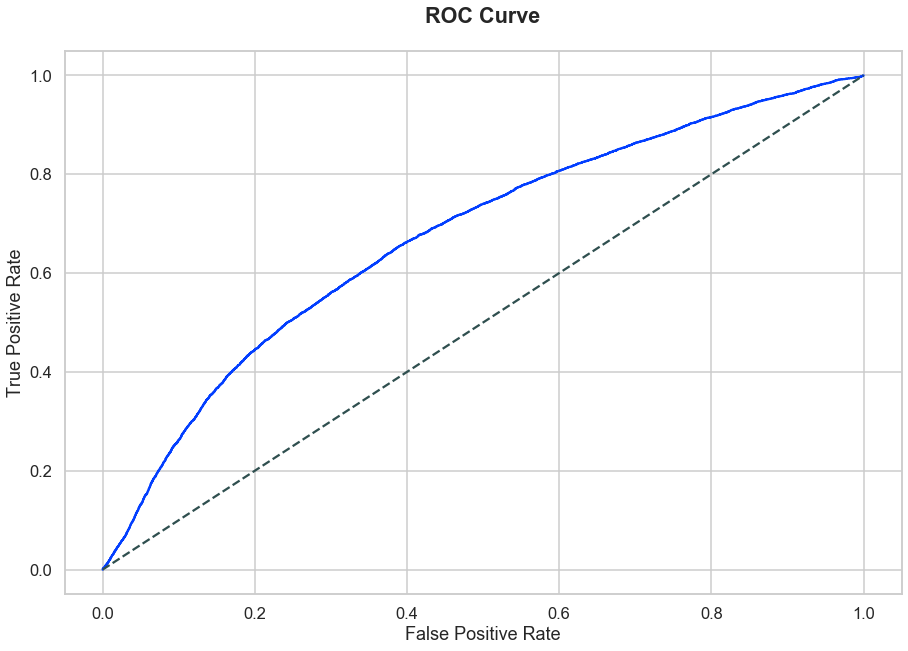

In [33]:
# getting probability estimates for `is_downtown`
y_pred_probs = lgtmodel.predict_proba(X_test[logit_variables])[:,1]

# plotting ROC curve and 45-degree line
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(15,10))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],color="darkslategray", linestyle="dashed")

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve", fontweight="bold", fontsize="large", y=1.04)
plt.show()

The ROC curve above illustrates the diagnostic ability of our model at different discrimination thresholds. With the goal of maximizing the true positive rate while minimizing the false positive rate, we select a threshold of 0.22 for our model. 

In [34]:
# using 0.22 descrimination threshold and getting predictions for `is_downtown`
y_pred = lgtmodel.predict_proba(X_test)[:,1]>0.22

# creating confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(confusion_matrix(y_test, y_pred))

[[12754 11208]
 [ 2242  5696]]


Based on the confusion matrix above, our model has 5696 true positives, 11208 false positives, 12754 true negatives and 2242 false negatives. This yields a true positive rate of 71.8% and a false positive rate of 46.8%. In other words, our model predicts that `is_downtown` is true when it is actually true 71.8% of the time , and it mistakenly predicts that `is_downtown` is true when it is actually false 46.8% of the time. 

In [35]:
# getting accuracy score of logistic regression model
lgtscore=lgtmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Logistic Regression is {lgtscore}")

Mean Accuracy Score of Logistic Regression is 0.7473354231974921


Our logistic regression model yields a mean accuracy score of 0.747, meaning that it classifies `is_downtown` values correctly 74.7% of the time. Can we make better predictions with other binary classifiers?

## 5.4 Other Binary Classifiers

The other binary classifiers we experiment with are K Nearest Neighbors, random forests, adaptive boosting (AdaBoost) and decision trees. 

In [36]:
# fitting a k neighbors classifier to data and getting its accuracy score
knmodel = KNeighborsClassifier(60)
knmodel.fit(X_train,y_train)
knscore=knmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of K Nearest Neighbors Classifier is {knscore}")

Mean Accuracy Score of K Nearest Neighbors Classifier is 0.7542319749216301


In [37]:
# fitting a random forest classifier to data and getting its accuracy score
rfmodel = RandomForestClassifier(max_depth=5, n_estimators=5)
rfmodel.fit(X_train,y_train)
rfscore=rfmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Random Forest Classifier is {rfscore}")

Mean Accuracy Score of Random Forest Classifier is 0.7515673981191222


In [38]:
# fitting an adaboost classifier to data and getting its accuracy score
adbmodel = AdaBoostClassifier()
adbmodel.fit(X_train,y_train)
adbscore=adbmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Adaptive Boosting Classifier is {adbscore}")

Mean Accuracy Score of Adaptive Boosting Classifier is 0.7520689655172413


In [39]:
# fitting decision tree classifier to data and getting its accuracy score
dtmodel = DecisionTreeClassifier(max_depth=10)
dtmodel.fit(X_train,y_train)
dtscore=dtmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Decision Trees Classifier is {dtscore}")

Mean Accuracy Score of Decision Trees Classifier is 0.754514106583072


Among the four binary classifiers above, all of them have outperformed our logistic regression model slightly in terms of mean accuracy score. The model with the highest prediction accuracy is the decision trees classifier. 

# 6. Conclusion

Without a doubt, the taxi system is an integral part of New York City, so much so that many people may have trouble imagining the city without its distinctive yellow cabs. All day, everyday, taxis travel throughout the crowded streets, keeping the city running smoothly and delivering people from one place to the next. As part of a greater whole, however, the taxi system is also subject to many external factors that can influence when and where, how far and for how long they travel.  

## 6.1 Summary and Interpretation of Key Findings
Our key findings are as follows:
1. **General Trends:** 
 - Taxi ridership exhibits strong seasonality, on a monthly and daily scale. On a monthly scale, taxi ridership followed a general declining trend over the first 8 months of 2019. On a daily scale, taxi ridership varies a lot at different times of the day, with 8 times more hourly rides at 6-7pm than at 4-5am. We imagine the spike in taxi ridership at 6-7pm is due to people getting off from work and heading to afterwork events or dinner, while the lull in trip counts at 4-5am arises from interval between late-night parties and commutes to work. 
 <br />
 
 - The vast majority of NYC taxi rides are short hops, with a median distance of just 1.64 miles. The median speed clocked on a taxi ride is surprisingly slow, at 9.96 miles per hour. If policymakers would like to increase ridership on NYC's taxis (especially since the taxis are all hybrid, green vehicles), they could consider allowing taxis to use fast-track lanes during certain hours.  
 - The early morning hours have a much higher density of hourly taxi rides on weekends than on weekdays, corresponding to a late-night party crowd on weekends. There is a much steeper increase in the density of hourly taxi rides from 6-10am on weekdays than on weekends, suggestive of the reliance on taxis to get to work as offices open at 8-10am for the day. 
 

2. **Best Predictors of Daily Trip Counts:** 
 - Weather has a strong relationship with daily trip counts, both in terms of correlations and regression coefficients (where covariates are held constant). A sharp drop in daily taxi ridership occurs with an increase in average temperature or new daily snowfall. Perhaps, warmer weather spurs New Yorkers to consider more active transport options (e.g. walking, Citibikes), while fresh snow, which clogs up roads and slows traffic, convinces New Yorkers to use the subway instead. 
 <br />
 
 - Both day of week and 2019 month are key predictors of daily taxi ridership. Sundays are linked to much fewer daily trips, while Thursdays and Fridays are linked to the highest daily trip counts. The months of January to May 2019 are linked to an climbing trend in daily ridership, but June to August 2019 are linked to a precipitous fall in daily trip counts. This dropoff could be due to uncaptured attributes, such as the reduction in young taxi riders from June to August as NYC universities close for the summer. 
 
 
3. **Best Predictors of a Downtown Pickup/Dropoff for Manhattan Rides**
 - Among taxi rides in Manhattan, time of day and day of week are important predictors of downtown ride odds. In particular, a late-night pickup/dropoff increases the odds of a downtown ride substantially, just as a weekend pickup/dropoff does. Since a large fraction of clubs, poetry cafes and late-night bars are situated in the downtown area (e.g. Soho, Greenwich Village, East Village), it makes sense that downtown is a hotspot for taxi ridership on late weekend nights. 
 <br />
 
 - Card payment is linked to a sharp increase in downtown ride odds, suggesting that downtown commuters are more inclined/able to pay by credit card instead of cash. We believe that this correlates with the higher average wealth of workers in the downtown district, where finance, technology and consulting companies abound. 
 <br />
 
 - A higher total amount paid is linked to greater odds of a downtown ride, when covariates are held constant. This could be due to the higher mean trip distance of downtown rides (over 0.5 miles higher than rides in other Manhattan areas). 

## 6.2 Confidence in Results
We are fairly confident in the results of data analysis, for the following reasons:
- **Quality of Input:** Our projects draws a large sample (over 100,000 observations) from a dataset with low incidence rate of major irregularities (e.g. null or nonsensical values). Upon scrutinizing the dataset for minor irregularities, we only found a few hundred cases (e.g. entries with a trip distance  of 0 but over \\$100 in fare amounts). We took steps to tackle these minor irregularities, by creating assumptions of what constituted a "valid" taxi ride (e.g. nonzero values for `fare_amount`, `total_amount`, `trip_distance` and `trip_duration_mins`). 


- **High Significance Levels of Regression Coefficients:** For both our linear and logistic regression models, the regression coefficients that we interpreted were all highly significant. Many were significant not just at a 5\% level, but at a 1\% level as well. 


- **Fairly High Significance Levels and Explanatory Power of Models:** Both models achieved the best balance between goodness of fit and prevention of overfitting (with the variables they were fed), by using the AIC optimization function. The models were highly significant at a 5\% level using the F-test, and the linear regression model had a R-squared value of 0.717 indicating its decent explanatory power. 

However, we caution against making any predictions using our linear regression model, given its violation of two assumptions of linear regression&mdash;normally distributed and mutually independent residuals. 

## 6.3 Next Steps
Further research is needed if we are to gain an even more accurate and detailed understanding of NYC taxi ridership. Given the inability of our linear regression model to predict taxi ridership in NYC, various steps (e.g. nonlinear transformation of variables or replacement of the regressor) must be taken to create a model that yields unbiased predictions. 

Reflecting limitations in scope, our study focused solely on the months of January-August 2019. Thus, we were unable to consider larger trends over time, and some of our data may be unrepresentative of taxi ridership over longer spans of time (e.g. 5 years). Furthermore, external research on NYC culture could give us a deeper understanding of what are the "softer" behavioral elements at play influencing where people go, why, and when. Our interpretations of the data and visualization, while reasonable, are made from an outsider’s point of view, and perhaps lack important insider knowledge. If given the opportunity, we would expand our data analysis and seek to answer questions such as: What factors influence why trips to some locations that are more popular than others? How do special events like a large concert or parade affect taxi ridership? And is there a demographic that is more likely to ride a taxi than others? We hope that this project provide a foundation for further research on the NYC taxi ridership to answer questions like these and more.


# 7. Source Code

The code that documents our data cleaning and preprocessing efforts can be found within the "Data Cleaning (NYC Taxi Ridership Project).ipynb" file at https://github.com/em682/INFO2950FinalProject. Our curated dataset (post-cleaning and preprocessing) can be found at https://cornell.box.com/s/cptp2tgln6sxo86ecfmszfrzwew0qud9.

# 8. Acknowledgments


We would like to express our sincere gratitude for the contributions by the following sources: 


**People**
- Professor David Mimno: We learned about regression, correlation interpretations and the use of packages such as Matplotlib in his class. He thus gave us both the theoretical framework and technical skills to perform our data analysis. 


- Professor Madeleine Udell: The testing of assumptions for linear and logistic regression models, along with the use of binary classifiers, was taught in her class (ORIE 3120). We also adapted her code for the minAIC and minOLS functions, which helped us immensely in optimizing our regression models. 


**Online Resources**
- Stack Overflow 
 - https://stackoverflow.com/questions/29440568/pandas-replacement-not-allowed-with-overlapping-keys-and-values
 - https://stackoverflow.com/questions/42425971/overlapping-keys-in-dictionary-when-using-replace-method-on-pandas-dataframe
 - https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
 - https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot
 - https://stackoverflow.com/questions/2418125/matplotlib-subplots-adjust-hspace-so-titles-and-xlabels-dont-overlap
 - https://stackoverflow.com/questions/18022845/pandas-index-column-title-or-name
 - https://stackoverflow.com/questions/9847213/how-do-i-get-the-day-of-week-given-a-date
 - https://stackoverflow.com/questions/16766643/convert-date-string-to-day-of-week/16766750
 - https://stackoverflow.com/questions/46307941/how-can-i-add-title-on-seaborn-lmplot
 - https://stackoverflow.com/questions/31859285/rotate-tick-labels-for-seaborn-barplot
 - https://stackoverflow.com/questions/19079143/how-to-plot-time-series-in-python
 - https://stackoverflow.com/questions/33227473/how-to-set-the-range-of-y-axis-for-a-seaborn-boxplot
 - https://stackoverflow.com/questions/20701484/why-do-i-get-only-one-parameter-from-a-statsmodels-ols-fit
 - https://stackoverflow.com/questions/40088585/turn-off-error-bars-in-seaborn-bar-plot
 - https://stackoverflow.com/questions/19932553/size-of-figure-when-using-plt-subplots
 
 
- Towards Data Science
 - https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765
 - https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2
 - https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761
 - https://towardsdatascience.com/understanding-logistic-regression-coefficients-7a719ebebd35
 - https://towardsdatascience.com/one-tailed-or-two-tailed-test-that-is-the-question-1283387f631c
 - https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0
 - https://towardsdatascience.com/logistic-regression-python-7c451928efee
 - https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
 - https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
 - https://towardsdatascience.com/exploratory-data-analysis-in-python-c9a77dfa39ce
 
 
- Miscellaneous
 - http://people.duke.edu/~rnau/testing.htm
 - https://www.absentdata.com/python-graphs/create-a-heat-map-with-seaborn/
 - http://jose-coto.com/styling-with-seaborn
 - https://stackabuse.com/seaborn-library-for-data-visualization-in-python-part-2/
 - https://www.edureka.co/blog/python-seaborn-tutorial/#relationships
 - https://www.datarobot.com/blog/ordinary-least-squares-in-python/
 - https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/